# **Convert detailed management info to machine-readable format**

</br>

# Info

- This notebook converts detailed managament info available for the grassland research site [Chamau (CH-CHA)](https://www.swissfluxnet.ethz.ch/index.php/sites/site-info-ch-cha/) to a time series format.
- Management info is collected, simplified and then grouped into the following 7 management events:
    - `MGMT_SOILCULTIVATION`
    - `MGMT_PESTICIDE_HERBICIDE`
    - `MGMT_GRAZING`
    - `MGMT_MOWING`
    - `MGMT_SOWING`
    - `MGMT_FERT_ORG`
    - `MGMT_FERT_MIN`
- Multiple variants are created for each event, example for `MGMT_FERT_ORG`:
    - `MGMT_FERT_ORG` ... application of mineral fertilizer on either of the parcels    
    - `MGMT_FERT_ORG_PARCEL-A` ... only in parcel A
    - `MGMT_FERT_ORG_PARCEL-B` ... only in parcel B
    - `MGMT_FERT_ORG_FOOTPRINT` ... in footprint, corresponds to `MGMT_FERT_ORG_PARCEL-A` or `MGMT_FERT_ORG_PARCEL-B` depending on wind direction
- In addition, `TIMESINCE` variables are created for all events, counting the *days* since the last occurrence of the respective event
    - Example: `TIMESINCE_MGMT_FERT_ORG` is the time in days since the last fertilization with organic fertilizer to either parcel A or parcel B

</br>

---

# Imports

---

In [1]:
import datetime
from collections import Counter
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from diive.core.io.files import save_parquet, load_parquet
from diive.pkgs.createvar.timesince import TimeSince
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.core.plotting.timeseries import TimeSeries

</br>

</br>

---

# Read data

---

## Read wind direction data from merged flux data
- Here only needed for wind direction `WD`

In [2]:
FILEPATH = r"../30_MERGE_DATA/31.1_CH-CHA_IRGA_Level-1_eddypro_fluxnet_2005-2024.parquet"
fluxdf = load_parquet(filepath=FILEPATH)
winddir = fluxdf['WD'].copy()
winddir

Loaded .parquet file ../30_MERGE_DATA/31.1_CH-CHA_IRGA_Level-1_eddypro_fluxnet_2005-2024.parquet (2.400 seconds).
    --> Detected time resolution of <30 * Minutes> / 30min 


TIMESTAMP_MIDDLE
2005-07-26 16:15:00    337.570
2005-07-26 16:45:00    355.535
2005-07-26 17:15:00    326.946
2005-07-26 17:45:00    322.329
2005-07-26 18:15:00    317.961
                        ...   
2024-12-31 22:45:00    183.899
2024-12-31 23:15:00    198.289
2024-12-31 23:45:00    200.110
2025-01-01 00:15:00    234.624
2025-01-01 00:45:00    231.255
Freq: 30min, Name: WD, Length: 340722, dtype: float64

## Read management data

In [3]:
file_mgmt = r"../0_data/MANAGEMENT/CH-CHA-Management_2005-2024_20250107.xlsx"
sheet = "CHA_Management"
mgmt_detailed = pd.read_excel(file_mgmt, sheet_name=sheet)
mgmt_detailed = mgmt_detailed.loc[:, ['Parcel', 'Management_Category', 'Management_Subcategory', 'Management_specific', 'Start', 'End', 'Total Fertilizer N (kg/ha)']]
mgmt_detailed 

Parcel                      Management_Category Management_Subcategory Management_specific      Start        End  Total Fertilizer N (kg/ha)
0        A                            Fertilization     Organic fertilizer              Manure 2001-01-15        NaT                  206.700313
1        A  Plant protection and growth maintenance          Herbe removal       Rumex removal 2001-03-30        NaT                         NaN
2        A  Plant protection and growth maintenance              Harrowing    Harrowing (1 cm) 2001-04-02        NaT                         NaN
3        A                                      Use                Grazing              Cattle 2001-05-07 2001-05-15                         NaN
4        A  Plant protection and growth maintenance                Rolling                 NaN 2001-06-07        NaT                         NaN
..     ...                                      ...                    ...                 ...        ...        ...                         ...
575      B                                      Use                 Mowing                 NaN 2024-07-17 2024-07-17                         NaN
576      B                            Fertilization     Organic fertilizer              Slurry 2024-08-07 2024-08-07                   59.414520
577      B                                      Use                 Mowing                 NaN 2024-08-22 2024-08-22                         NaN
578      B                            Fertilization     Organic fertilizer              Slurry 2024-08-27 2024-08-27                   74.634175
579      B                                      Use                Grazing               Sheep 2024-11-08 2024-11-19                         NaN

[580 rows x 7 columns]

</br>

</br>

---

# **MANAGEMENT EVENTS DAILY** (daily scale)

---

## Handle missing management info

In [4]:
# Some dates have time info, removed in this step, keep only date
mgmt_detailed['Start'] = pd.to_datetime(mgmt_detailed['Start']).dt.date
mgmt_detailed['End'] = pd.to_datetime(mgmt_detailed['End']).dt.date

In [5]:
# Fill end dates, if missing then end is the same as start
mgmt_detailed['End'] = mgmt_detailed['End'].fillna(mgmt_detailed['Start'])

mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].fillna('-9999')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].fillna('-9999')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].fillna('-9999')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].fillna('-9999')
mgmt_detailed['Total Fertilizer N (kg/ha)'] = mgmt_detailed['Total Fertilizer N (kg/ha)'].fillna(0)
mgmt_detailed

Parcel                      Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha)
0        A                            Fertilization     Organic fertilizer              Manure  2001-01-15  2001-01-15                  206.700313
1        A  Plant protection and growth maintenance          Herbe removal       Rumex removal  2001-03-30  2001-03-30                    0.000000
2        A  Plant protection and growth maintenance              Harrowing    Harrowing (1 cm)  2001-04-02  2001-04-02                    0.000000
3        A                                      Use                Grazing              Cattle  2001-05-07  2001-05-15                    0.000000
4        A  Plant protection and growth maintenance                Rolling               -9999  2001-06-07  2001-06-07                    0.000000
..     ...                                      ...                    ...                 ...         ...         ...                         ...
575      B                                      Use                 Mowing               -9999  2024-07-17  2024-07-17                    0.000000
576      B                            Fertilization     Organic fertilizer              Slurry  2024-08-07  2024-08-07                   59.414520
577      B                                      Use                 Mowing               -9999  2024-08-22  2024-08-22                    0.000000
578      B                            Fertilization     Organic fertilizer              Slurry  2024-08-27  2024-08-27                   74.634175
579      B                                      Use                Grazing               Sheep  2024-11-08  2024-11-19                    0.000000

[580 rows x 7 columns]

In [6]:
# mgmt_detailed.count()

In [7]:
# ## Make full timestamp for start and end dates
# - The full timestamp for start and end dates takes into account that the flux records are stored with a timestamp that shows the END of the averaging interval
# - This means that a record with timestamp `2021-06-05 00:00` contains data between `2021-06-04 23:30` (exclusive) and `2021-06-05 00:00` (inclusive)
# - To correctly assign a management to a specific day, one second needs to be added to the start date (because the time 00:00 still has data from the *previous* day)
# - For the end data to cover the full day, 24 hours need to be added and in addition one second, to include the 00:00 time of the next day
# mgmt_detailed['Start'] = pd.to_datetime(mgmt_detailed['Start']).add(datetime.timedelta(seconds=1))
# mgmt_detailed['End'] = pd.to_datetime(mgmt_detailed['End']).add(datetime.timedelta(hours=24, seconds=1))
# mgmt_detailed

</br>

## Create `MGMT_SPECIFIC` variables

In [8]:
# Add PREFIX column, use MGMT when building variable names later
mgmt_detailed['PREFIX'] = 'MGMT'

# Rename parcels
mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].str.replace('A', 'PARCEL-A')
mgmt_detailed['Parcel'] = mgmt_detailed['Parcel'].str.replace('B', 'PARCEL-B')

### Rename Management_Category

In [9]:
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Fertilization', 'FERT')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Plant protection and growth maintenance', 'PPGM')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Use', 'USE')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Sowing', 'SOWING')
mgmt_detailed['Management_Category'] = mgmt_detailed['Management_Category'].str.replace('Soil cultivation', 'SOILCULTIVATION')

### Rename Management_Subcategory

In [10]:
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Organic fertilizer', 'ORG')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Mineral fertilizer', 'MIN')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Herbe removal', 'HERBREMOVAL')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Harrowing', 'HARROWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Grazing', 'GRAZING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Rolling', 'ROLLING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Oversowing', 'OVERSOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Mowing', 'MOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Herbicide', 'HERBICIDE')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Ploughing', 'PLOUGHING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Resowing', 'RESOWING')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Pesticide', 'PESTICIDE')
mgmt_detailed['Management_Subcategory'] = mgmt_detailed['Management_Subcategory'].str.replace('Tillage', 'TILLAGE')

### Rename Management_specific

In [11]:
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Manure', 'MAN')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Slurry', 'SLU')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Calcium ammonium nitrate', 'CAN')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Molluscicide (applied on the whole field)', 'MOLLUSCICIDE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harmony tabs (applied on single plants against Rumex obtusifolius)', 'HARMONYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Ally Tabs (applied on single plants against Rumex spp.)', 'ALLYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Ally Tabs (applied against Rumex spp. and Senecio spp.)', 'ALLYTABS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Hay', 'HAY')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Sheep', 'SHEEP')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Cattle', 'CATTLE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Aftergrass', 'AFTERGRASS')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Asulox (applied on the whole field against Rumex obtusifolius)', 'ASULOX')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Rumex removal', 'RUMEX')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harrowing (1 cm)', '1CM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Harrowing (7 cm)', '7CM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Roundup PowerMax', 'ROUNDUP')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 Extra', 'OH440EXTRA')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('?', '-9999')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 RenoTurbo', 'OH440RENOTURBO')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 440 Reno', 'OH440RENO')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Type OH 240 Reno', 'OH240RENO')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Asulam (applied on the whole field against Rumex obtusifolius)', 'ASULAM')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Grass silage', 'GRASSSILAGE')
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('UFA 420', 'UFA-420')

s = "HEBE FIONA MERULA. Sorte HEBE: Trifolium repens (small leaves). Sorte FIONA: Trifolium repens (big leaves). Sorte MERULA: Trifolium pratense. Total 20 kg/ha. Mixture: 1/4 HEBE  1/2 FIONA 1/4 MERULA"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-MERULA')

s = "HEBE FIONA MERULA. Sorte HEBE: Trifolium repens (small leaves). Sorte FIONA: Trifolium repens (big leaves). Sorte MARULA: Trifolium pratense. Total 20 kg/ha. Mixture: 27% HEBE  36% FIONA 36% MERULA (15 kg + 20 kg + 20 kg)"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-MERULA')

s = "Type OH (HEBE FIONA TEDI). Trifolium pratense 4n Sorte TEDI - Trifolium repens Sorte HEBE - Trifolium repens Sorte FIONA. Total 200 g/a of each 1/3"
mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace(s, 'HEBE-FIONA-TEDI')

mgmt_detailed['Management_specific'] = mgmt_detailed['Management_specific'].str.replace('Hobelsaat (tillage until 3-4 cm)', '3-4CM')

### Assemble `MGMT_SPECIFIC`variable name

In [12]:
def create_varname(row): 
    return "_".join([
        row['PREFIX'],        
        row['Management_Category'], 
        row['Management_Subcategory'],
        str(row['Management_specific']),
        # row['Parcel']
    ])

mgmt_detailed['MGMT_SPECIFIC'] = mgmt_detailed.apply(create_varname, axis=1)
mgmt_detailed['MGMT_SPECIFIC'] = mgmt_detailed['MGMT_SPECIFIC'].str.replace('_-9999', '')
mgmt_types = mgmt_detailed['MGMT_SPECIFIC'].unique()

In [13]:
# List of unique specific managements
print("Unique specific managements:")
[print(f"{ix + 1}: {v}") for ix, v in enumerate(mgmt_types)];

Unique specific managements:
1: MGMT_FERT_ORG_MAN
2: MGMT_PPGM_HERBREMOVAL_RUMEX
3: MGMT_PPGM_HARROWING_1CM
4: MGMT_USE_GRAZING_CATTLE
5: MGMT_PPGM_ROLLING
6: MGMT_PPGM_HARROWING_7CM
7: MGMT_SOWING_OVERSOWING_OH440RENO
8: MGMT_USE_MOWING_GRASSSILAGE
9: MGMT_FERT_MIN_CAN
10: MGMT_FERT_ORG_SLU
11: MGMT_USE_GRAZING_SHEEP
12: MGMT_SOWING_OVERSOWING_OH440EXTRA
13: MGMT_USE_MOWING_AFTERGRASS
14: MGMT_PPGM_HERBICIDE_ASULOX
15: MGMT_SOILCULTIVATION_ROLLING
16: MGMT_USE_MOWING_HAY
17: MGMT_SOWING_OVERSOWING_OH440RENOTURBO
18: MGMT_SOWING_OVERSOWING_OH240RENO
19: MGMT_PPGM_HERBICIDE_ALLYTABS
20: MGMT_SOILCULTIVATION_PLOUGHING
21: MGMT_SOILCULTIVATION_HARROWING_7CM
22: MGMT_SOWING_RESOWING_OH440EXTRA
23: MGMT_PPGM_PESTICIDE_MOLLUSCICIDE
24: MGMT_PPGM_HERBICIDE_HARMONYTABS
25: MGMT_PPGM_HERBICIDE_ASULAM
26: MGMT_SOWING_OVERSOWING_HEBE-FIONA-TEDI
27: MGMT_SOILCULTIVATION_HARROWING_1CM
28: MGMT_USE_MOWING
29: MGMT_SOWING_OVERSOWING_HEBE-FIONA-MERULA
30: MGMT_PPGM_HERBICIDE_ROUNDUP
31: MGMT_SOILCULTI

In [14]:
mgmt_detailed

Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX                MGMT_SPECIFIC
0    PARCEL-A                FERT                    ORG                 MAN  2001-01-15  2001-01-15                  206.700313   MGMT            MGMT_FERT_ORG_MAN
1    PARCEL-A                PPGM            HERBREMOVAL               RUMEX  2001-03-30  2001-03-30                    0.000000   MGMT  MGMT_PPGM_HERBREMOVAL_RUMEX
2    PARCEL-A                PPGM              HARROWING                 1CM  2001-04-02  2001-04-02                    0.000000   MGMT      MGMT_PPGM_HARROWING_1CM
3    PARCEL-A                 USE                GRAZING              CATTLE  2001-05-07  2001-05-15                    0.000000   MGMT      MGMT_USE_GRAZING_CATTLE
4    PARCEL-A                PPGM                ROLLING               -9999  2001-06-07  2001-06-07                    0.000000   MGMT            MGMT_PPGM_ROLLING
..        ...                 ...                    ...                 ...         ...         ...                         ...    ...                          ...
575  PARCEL-B                 USE                 MOWING               -9999  2024-07-17  2024-07-17                    0.000000   MGMT              MGMT_USE_MOWING
576  PARCEL-B                FERT                    ORG                 SLU  2024-08-07  2024-08-07                   59.414520   MGMT            MGMT_FERT_ORG_SLU
577  PARCEL-B                 USE                 MOWING               -9999  2024-08-22  2024-08-22                    0.000000   MGMT              MGMT_USE_MOWING
578  PARCEL-B                FERT                    ORG                 SLU  2024-08-27  2024-08-27                   74.634175   MGMT            MGMT_FERT_ORG_SLU
579  PARCEL-B                 USE                GRAZING               SHEEP  2024-11-08  2024-11-19                    0.000000   MGMT       MGMT_USE_GRAZING_SHEEP

[580 rows x 9 columns]

### Counts of `MGMT_SPECIFIC`

In [15]:
counts = Counter(mgmt_detailed['MGMT_SPECIFIC'])
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
rename_dict = {'index': 'MGMT_SPECIFIC', 0: 'COUNTS'}
counts_df = counts_df.rename(columns=rename_dict, inplace=False)
counts_df = counts_df.sort_values(by='COUNTS', ascending=False)
counts_df.to_csv("22.1_mgmt_specific_counts.csv", index=False)
counts_df

MGMT_SPECIFIC  COUNTS
9                          MGMT_FERT_ORG_SLU     190
7                MGMT_USE_MOWING_GRASSSILAGE     134
10                    MGMT_USE_GRAZING_SHEEP      62
27                           MGMT_USE_MOWING      41
12                MGMT_USE_MOWING_AFTERGRASS      36
15                       MGMT_USE_MOWING_HAY      17
6           MGMT_SOWING_OVERSOWING_OH440RENO      12
3                    MGMT_USE_GRAZING_CATTLE       8
2                    MGMT_PPGM_HARROWING_1CM       8
0                          MGMT_FERT_ORG_MAN       7
8                          MGMT_FERT_MIN_CAN       7
14              MGMT_SOILCULTIVATION_ROLLING       6
18              MGMT_PPGM_HERBICIDE_ALLYTABS       5
23           MGMT_PPGM_HERBICIDE_HARMONYTABS       4
32                       MGMT_PPGM_HERBICIDE       4
1                MGMT_PPGM_HERBREMOVAL_RUMEX       3
16     MGMT_SOWING_OVERSOWING_OH440RENOTURBO       3
4                          MGMT_PPGM_ROLLING       3
31              MGMT_SOWING_RESOWING_UFA-420       3
24                MGMT_PPGM_HERBICIDE_ASULAM       2
22          MGMT_PPGM_PESTICIDE_MOLLUSCICIDE       2
17          MGMT_SOWING_OVERSOWING_OH240RENO       2
25    MGMT_SOWING_OVERSOWING_HEBE-FIONA-TEDI       2
21           MGMT_SOWING_RESOWING_OH440EXTRA       2
20        MGMT_SOILCULTIVATION_HARROWING_7CM       2
19            MGMT_SOILCULTIVATION_PLOUGHING       2
29               MGMT_PPGM_HERBICIDE_ROUNDUP       2
28  MGMT_SOWING_OVERSOWING_HEBE-FIONA-MERULA       2
30        MGMT_SOILCULTIVATION_TILLAGE_3-4CM       2
26        MGMT_SOILCULTIVATION_HARROWING_1CM       2
33            MGMT_SOILCULTIVATION_HARROWING       2
11         MGMT_SOWING_OVERSOWING_OH440EXTRA       1
5                    MGMT_PPGM_HARROWING_7CM       1
13                MGMT_PPGM_HERBICIDE_ASULOX       1

## Simplify and group `MGMT` variables
Group variables into 7 general categories:
- MGMT_MOWING, MGMT_GRAZING, MGMT_SOWING, MGMT_SOILCULTIVATION, MGMT_PESTICIDE_HERBICIDE, MGMT_FERT_ORG, MGMT_FERT_MIN

In [16]:
mgmt_detailed['MGMT_GENERAL'] = ''
mgmt_detailed['MGMT_PARCEL'] = ''

def rename(startswith, replacewith):
    
    locs = mgmt_detailed['MGMT_SPECIFIC'].str.startswith(startswith)

    mgmt_detailed.loc[locs, 'MGMT_GENERAL'] = replacewith
    mgmt_detailed.loc[locs, 'MGMT_PARCEL'] = replacewith + "_" + mgmt_detailed.loc[locs, 'Parcel']
    display(mgmt_detailed[locs].head(1))   
    print(f"Records: {len(mgmt_detailed[locs])}")

rename(startswith="MGMT_USE_MOWING", replacewith="MGMT_MOWING")

rename(startswith="MGMT_USE_GRAZING", replacewith="MGMT_GRAZING")

rename(startswith="MGMT_SOWING", replacewith="MGMT_SOWING")

rename(startswith="MGMT_SOILCULTIVATION", replacewith="MGMT_SOILCULTIVATION")
rename(startswith="MGMT_PPGM_HARROWING", replacewith="MGMT_SOILCULTIVATION")
rename(startswith="MGMT_PPGM_ROLLING", replacewith="MGMT_SOILCULTIVATION")

rename(startswith="MGMT_PPGM_PESTICIDE", replacewith="MGMT_PESTICIDE_HERBICIDE")
rename(startswith="MGMT_PPGM_HERBREMOVAL", replacewith="MGMT_PESTICIDE_HERBICIDE")
rename(startswith="MGMT_PPGM_HERBICIDE", replacewith="MGMT_PESTICIDE_HERBICIDE")

rename(startswith="MGMT_FERT_ORG", replacewith="MGMT_FERT_ORG")
rename(startswith="MGMT_FERT_MIN", replacewith="MGMT_FERT_MIN")

Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX                MGMT_SPECIFIC MGMT_GENERAL           MGMT_PARCEL
7  PARCEL-A                 USE                 MOWING         GRASSSILAGE  2001-07-25  2001-07-25                         0.0   MGMT  MGMT_USE_MOWING_GRASSSILAGE  MGMT_MOWING  MGMT_MOWING_PARCEL-A

Records: 228


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX            MGMT_SPECIFIC  MGMT_GENERAL            MGMT_PARCEL
3  PARCEL-A                 USE                GRAZING              CATTLE  2001-05-07  2001-05-15                         0.0   MGMT  MGMT_USE_GRAZING_CATTLE  MGMT_GRAZING  MGMT_GRAZING_PARCEL-A

Records: 70


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX                     MGMT_SPECIFIC MGMT_GENERAL           MGMT_PARCEL
6  PARCEL-A              SOWING             OVERSOWING           OH440RENO  2001-06-07  2001-06-07                         0.0   MGMT  MGMT_SOWING_OVERSOWING_OH440RENO  MGMT_SOWING  MGMT_SOWING_PARCEL-A

Records: 27


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX                 MGMT_SPECIFIC          MGMT_GENERAL                    MGMT_PARCEL
139  PARCEL-B     SOILCULTIVATION                ROLLING               -9999  2006-03-27  2006-03-27                         0.0   MGMT  MGMT_SOILCULTIVATION_ROLLING  MGMT_SOILCULTIVATION  MGMT_SOILCULTIVATION_PARCEL-B

Records: 16


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX            MGMT_SPECIFIC          MGMT_GENERAL                    MGMT_PARCEL
2  PARCEL-A                PPGM              HARROWING                 1CM  2001-04-02  2001-04-02                         0.0   MGMT  MGMT_PPGM_HARROWING_1CM  MGMT_SOILCULTIVATION  MGMT_SOILCULTIVATION_PARCEL-A

Records: 9


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX      MGMT_SPECIFIC          MGMT_GENERAL                    MGMT_PARCEL
4  PARCEL-A                PPGM                ROLLING               -9999  2001-06-07  2001-06-07                         0.0   MGMT  MGMT_PPGM_ROLLING  MGMT_SOILCULTIVATION  MGMT_SOILCULTIVATION_PARCEL-A

Records: 3


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX                     MGMT_SPECIFIC              MGMT_GENERAL                        MGMT_PARCEL
306  PARCEL-A                PPGM              PESTICIDE        MOLLUSCICIDE  2012-06-19  2012-06-19                         0.0   MGMT  MGMT_PPGM_PESTICIDE_MOLLUSCICIDE  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-A

Records: 2


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX                MGMT_SPECIFIC              MGMT_GENERAL                        MGMT_PARCEL
1  PARCEL-A                PPGM            HERBREMOVAL               RUMEX  2001-03-30  2001-03-30                         0.0   MGMT  MGMT_PPGM_HERBREMOVAL_RUMEX  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-A

Records: 3


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX               MGMT_SPECIFIC              MGMT_GENERAL                        MGMT_PARCEL
70  PARCEL-B                PPGM              HERBICIDE              ASULOX  2003-09-22  2003-09-22                         0.0   MGMT  MGMT_PPGM_HERBICIDE_ASULOX  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-B

Records: 18


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX      MGMT_SPECIFIC   MGMT_GENERAL             MGMT_PARCEL
0  PARCEL-A                FERT                    ORG                 MAN  2001-01-15  2001-01-15                  206.700313   MGMT  MGMT_FERT_ORG_MAN  MGMT_FERT_ORG  MGMT_FERT_ORG_PARCEL-A

Records: 197


Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX      MGMT_SPECIFIC   MGMT_GENERAL             MGMT_PARCEL
8  PARCEL-A                FERT                    MIN                 CAN  2001-08-06  2001-08-06                       17.55   MGMT  MGMT_FERT_MIN_CAN  MGMT_FERT_MIN  MGMT_FERT_MIN_PARCEL-A

Records: 7


In [17]:
mgmt_detailed

Parcel Management_Category Management_Subcategory Management_specific       Start         End  Total Fertilizer N (kg/ha) PREFIX                MGMT_SPECIFIC              MGMT_GENERAL                        MGMT_PARCEL
0    PARCEL-A                FERT                    ORG                 MAN  2001-01-15  2001-01-15                  206.700313   MGMT            MGMT_FERT_ORG_MAN             MGMT_FERT_ORG             MGMT_FERT_ORG_PARCEL-A
1    PARCEL-A                PPGM            HERBREMOVAL               RUMEX  2001-03-30  2001-03-30                    0.000000   MGMT  MGMT_PPGM_HERBREMOVAL_RUMEX  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-A
2    PARCEL-A                PPGM              HARROWING                 1CM  2001-04-02  2001-04-02                    0.000000   MGMT      MGMT_PPGM_HARROWING_1CM      MGMT_SOILCULTIVATION      MGMT_SOILCULTIVATION_PARCEL-A
3    PARCEL-A                 USE                GRAZING              CATTLE  2001-05-07  2001-05-15                    0.000000   MGMT      MGMT_USE_GRAZING_CATTLE              MGMT_GRAZING              MGMT_GRAZING_PARCEL-A
4    PARCEL-A                PPGM                ROLLING               -9999  2001-06-07  2001-06-07                    0.000000   MGMT            MGMT_PPGM_ROLLING      MGMT_SOILCULTIVATION      MGMT_SOILCULTIVATION_PARCEL-A
..        ...                 ...                    ...                 ...         ...         ...                         ...    ...                          ...                       ...                                ...
575  PARCEL-B                 USE                 MOWING               -9999  2024-07-17  2024-07-17                    0.000000   MGMT              MGMT_USE_MOWING               MGMT_MOWING               MGMT_MOWING_PARCEL-B
576  PARCEL-B                FERT                    ORG                 SLU  2024-08-07  2024-08-07                   59.414520   MGMT            MGMT_FERT_ORG_SLU             MGMT_FERT_ORG             MGMT_FERT_ORG_PARCEL-B
577  PARCEL-B                 USE                 MOWING               -9999  2024-08-22  2024-08-22                    0.000000   MGMT              MGMT_USE_MOWING               MGMT_MOWING               MGMT_MOWING_PARCEL-B
578  PARCEL-B                FERT                    ORG                 SLU  2024-08-27  2024-08-27                   74.634175   MGMT            MGMT_FERT_ORG_SLU             MGMT_FERT_ORG             MGMT_FERT_ORG_PARCEL-B
579  PARCEL-B                 USE                GRAZING               SHEEP  2024-11-08  2024-11-19                    0.000000   MGMT       MGMT_USE_GRAZING_SHEEP              MGMT_GRAZING              MGMT_GRAZING_PARCEL-B

[580 rows x 11 columns]

In [18]:
mgmt_detailed.to_csv("22.2_mgmt_detailed.csv")

In [19]:
print("Check for missing management info:")
mgmt_detailed.isnull().sum()

Check for missing management info:


Parcel                        0
Management_Category           0
Management_Subcategory        0
Management_specific           0
Start                         0
End                           0
Total Fertilizer N (kg/ha)    0
PREFIX                        0
MGMT_SPECIFIC                 0
MGMT_GENERAL                  0
MGMT_PARCEL                   0
dtype: int64

### Count `MGMT_PARCEL` events

In [20]:
counts = Counter(mgmt_detailed['MGMT_PARCEL'])
counts_df = pd.DataFrame.from_dict(counts, orient='index').reset_index()
rename_dict = {'index': 'MGMT_PARCEL', 0: 'COUNTS'}
counts_df = counts_df.rename(columns=rename_dict, inplace=False)
counts_df = counts_df.sort_values(by='COUNTS', ascending=False)
counts_df.to_csv("22.3_mgmt_parcel_counts.csv", index=False)
counts_df

MGMT_PARCEL  COUNTS
9                MGMT_MOWING_PARCEL-B     118
0              MGMT_FERT_ORG_PARCEL-A     112
5                MGMT_MOWING_PARCEL-A     110
7              MGMT_FERT_ORG_PARCEL-B      85
11              MGMT_GRAZING_PARCEL-B      36
3               MGMT_GRAZING_PARCEL-A      34
12               MGMT_SOWING_PARCEL-B      21
8       MGMT_SOILCULTIVATION_PARCEL-B      17
10  MGMT_PESTICIDE_HERBICIDE_PARCEL-B      12
1   MGMT_PESTICIDE_HERBICIDE_PARCEL-A      11
2       MGMT_SOILCULTIVATION_PARCEL-A      11
4                MGMT_SOWING_PARCEL-A       6
6              MGMT_FERT_MIN_PARCEL-A       5
13             MGMT_FERT_MIN_PARCEL-B       2

## Collect management info in daily dataframe

### Create daily timestamp, starting with year of first management event in 2001

In [21]:
timestamp_daily = pd.date_range("2001-01-01", fluxdf.index[-1].date(), freq='d')
timestamp_daily

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09', '2001-01-10',
               ...
               '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30', '2024-12-31', '2025-01-01'], dtype='datetime64[ns]', length=8767, freq='D')

In [22]:
# ## Create full timestamp, starting with year of first management event in 2001
# timestamp_full = pd.date_range("2001-01-01 00:15:00", fluxdf.index[-1], freq='30min')
# timestamp_full

### Create empty dataframe

In [23]:
cols = counts_df['MGMT_PARCEL'].tolist()
mgmt_daily = pd.DataFrame(index=timestamp_daily, columns=cols)
mgmt_daily.index

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04', '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08', '2001-01-09', '2001-01-10',
               ...
               '2024-12-23', '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29', '2024-12-30', '2024-12-31', '2025-01-01'], dtype='datetime64[ns]', length=8767, freq='D')

### Insert *parcel* management info into management dataframe with daily timestamp

In [24]:
for ix, event in mgmt_detailed.iterrows():
    varname = event['MGMT_PARCEL']
    start = event['Start']
    end = event['End']
    print(f"from {start} to {end}: {varname}")
    locs = (mgmt_daily.index.date >= start) & (mgmt_daily.index.date <= end)    
    mgmt_daily.loc[locs, varname] = 1    

mgmt_daily = mgmt_daily.fillna(0)

from 2001-01-15 to 2001-01-15: MGMT_FERT_ORG_PARCEL-A
from 2001-03-30 to 2001-03-30: MGMT_PESTICIDE_HERBICIDE_PARCEL-A
from 2001-04-02 to 2001-04-02: MGMT_SOILCULTIVATION_PARCEL-A
from 2001-05-07 to 2001-05-15: MGMT_GRAZING_PARCEL-A
from 2001-06-07 to 2001-06-07: MGMT_SOILCULTIVATION_PARCEL-A
from 2001-06-07 to 2001-06-07: MGMT_SOILCULTIVATION_PARCEL-A
from 2001-06-07 to 2001-06-07: MGMT_SOWING_PARCEL-A
from 2001-07-25 to 2001-07-25: MGMT_MOWING_PARCEL-A
from 2001-08-06 to 2001-08-06: MGMT_FERT_MIN_PARCEL-A
from 2001-08-21 to 2001-08-23: MGMT_MOWING_PARCEL-A
from 2001-09-12 to 2001-09-12: MGMT_PESTICIDE_HERBICIDE_PARCEL-A
from 2001-10-15 to 2001-10-16: MGMT_MOWING_PARCEL-A
from 2001-01-16 to 2001-01-16: MGMT_FERT_ORG_PARCEL-B
from 2001-03-30 to 2001-03-30: MGMT_FERT_ORG_PARCEL-B
from 2001-04-20 to 2001-04-20: MGMT_SOILCULTIVATION_PARCEL-B
from 2001-05-09 to 2001-05-10: MGMT_MOWING_PARCEL-B
from 2001-05-11 to 2001-05-11: MGMT_FERT_ORG_PARCEL-B
from 2001-05-22 to 2001-05-22: MGMT_PESTICI

C:\Users\nopan\AppData\Local\Temp\ipykernel_20820\573936329.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mgmt_daily = mgmt_daily.fillna(0)


### Insert *general (both parcels)* management info into management dataframe with daily timestamp

In [25]:
for ix, event in mgmt_detailed.iterrows():
    varname = event['MGMT_GENERAL']
    start = event['Start']
    end = event['End']
    print(f"from {start} to {end}: {varname}")
    locs = (mgmt_daily.index.date >= start) & (mgmt_daily.index.date <= end)    
    mgmt_daily.loc[locs, varname] = 1    

mgmt_daily = mgmt_daily.fillna(0)

from 2001-01-15 to 2001-01-15: MGMT_FERT_ORG
from 2001-03-30 to 2001-03-30: MGMT_PESTICIDE_HERBICIDE
from 2001-04-02 to 2001-04-02: MGMT_SOILCULTIVATION
from 2001-05-07 to 2001-05-15: MGMT_GRAZING
from 2001-06-07 to 2001-06-07: MGMT_SOILCULTIVATION
from 2001-06-07 to 2001-06-07: MGMT_SOILCULTIVATION
from 2001-06-07 to 2001-06-07: MGMT_SOWING
from 2001-07-25 to 2001-07-25: MGMT_MOWING
from 2001-08-06 to 2001-08-06: MGMT_FERT_MIN
from 2001-08-21 to 2001-08-23: MGMT_MOWING
from 2001-09-12 to 2001-09-12: MGMT_PESTICIDE_HERBICIDE
from 2001-10-15 to 2001-10-16: MGMT_MOWING
from 2001-01-16 to 2001-01-16: MGMT_FERT_ORG
from 2001-03-30 to 2001-03-30: MGMT_FERT_ORG
from 2001-04-20 to 2001-04-20: MGMT_SOILCULTIVATION
from 2001-05-09 to 2001-05-10: MGMT_MOWING
from 2001-05-11 to 2001-05-11: MGMT_FERT_ORG
from 2001-05-22 to 2001-05-22: MGMT_PESTICIDE_HERBICIDE
from 2001-05-25 to 2001-06-10: MGMT_GRAZING
from 2001-07-25 to 2001-07-26: MGMT_MOWING
from 2001-08-21 to 2001-08-23: MGMT_MOWING
from 2002-

In [26]:
# mgmt_daily.loc['2002-05-20':'2002-05-23']

In [27]:
mgmt_daily = mgmt_daily.reindex(sorted(mgmt_daily.columns), axis=1)

In [28]:
mgmt_daily

MGMT_FERT_MIN  MGMT_FERT_MIN_PARCEL-A  MGMT_FERT_MIN_PARCEL-B  MGMT_FERT_ORG  MGMT_FERT_ORG_PARCEL-A  MGMT_FERT_ORG_PARCEL-B  MGMT_GRAZING  MGMT_GRAZING_PARCEL-A  MGMT_GRAZING_PARCEL-B  MGMT_MOWING  MGMT_MOWING_PARCEL-A  MGMT_MOWING_PARCEL-B  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-A  MGMT_PESTICIDE_HERBICIDE_PARCEL-B  MGMT_SOILCULTIVATION  MGMT_SOILCULTIVATION_PARCEL-A  MGMT_SOILCULTIVATION_PARCEL-B  MGMT_SOWING  MGMT_SOWING_PARCEL-A  MGMT_SOWING_PARCEL-B
2001-01-01            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0                   0.0                              0                              0          0.0                     0                     0
2001-01-02            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0                   0.0                              0                              0          0.0                     0                     0
2001-01-03            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0                   0.0                              0                              0          0.0                     0                     0
2001-01-04            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0                   0.0                              0                              0          0.0                     0                     0
2001-01-05            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0                   0.0                              0                              0          0.0                     0                     0
...                   ...                     ...                     ...            ...                     ...                     ...           ...                    ...                    ...          ...                   ...                   ...                       ...                                ...                                ...                   ...                            ...                            ...          ...                   ...                   ...
2024-12-28            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0                   0.0                              0                              0          0.0                     0                     0
2024-12-29            0.0                       0                       0           

In [29]:
mgmt_daily.columns

Index(['MGMT_FERT_MIN', 'MGMT_FERT_MIN_PARCEL-A', 'MGMT_FERT_MIN_PARCEL-B', 'MGMT_FERT_ORG', 'MGMT_FERT_ORG_PARCEL-A', 'MGMT_FERT_ORG_PARCEL-B', 'MGMT_GRAZING', 'MGMT_GRAZING_PARCEL-A', 'MGMT_GRAZING_PARCEL-B', 'MGMT_MOWING', 'MGMT_MOWING_PARCEL-A', 'MGMT_MOWING_PARCEL-B', 'MGMT_PESTICIDE_HERBICIDE', 'MGMT_PESTICIDE_HERBICIDE_PARCEL-A', 'MGMT_PESTICIDE_HERBICIDE_PARCEL-B', 'MGMT_SOILCULTIVATION', 'MGMT_SOILCULTIVATION_PARCEL-A', 'MGMT_SOILCULTIVATION_PARCEL-B', 'MGMT_SOWING', 'MGMT_SOWING_PARCEL-A', 'MGMT_SOWING_PARCEL-B'], dtype='object')

### Plots

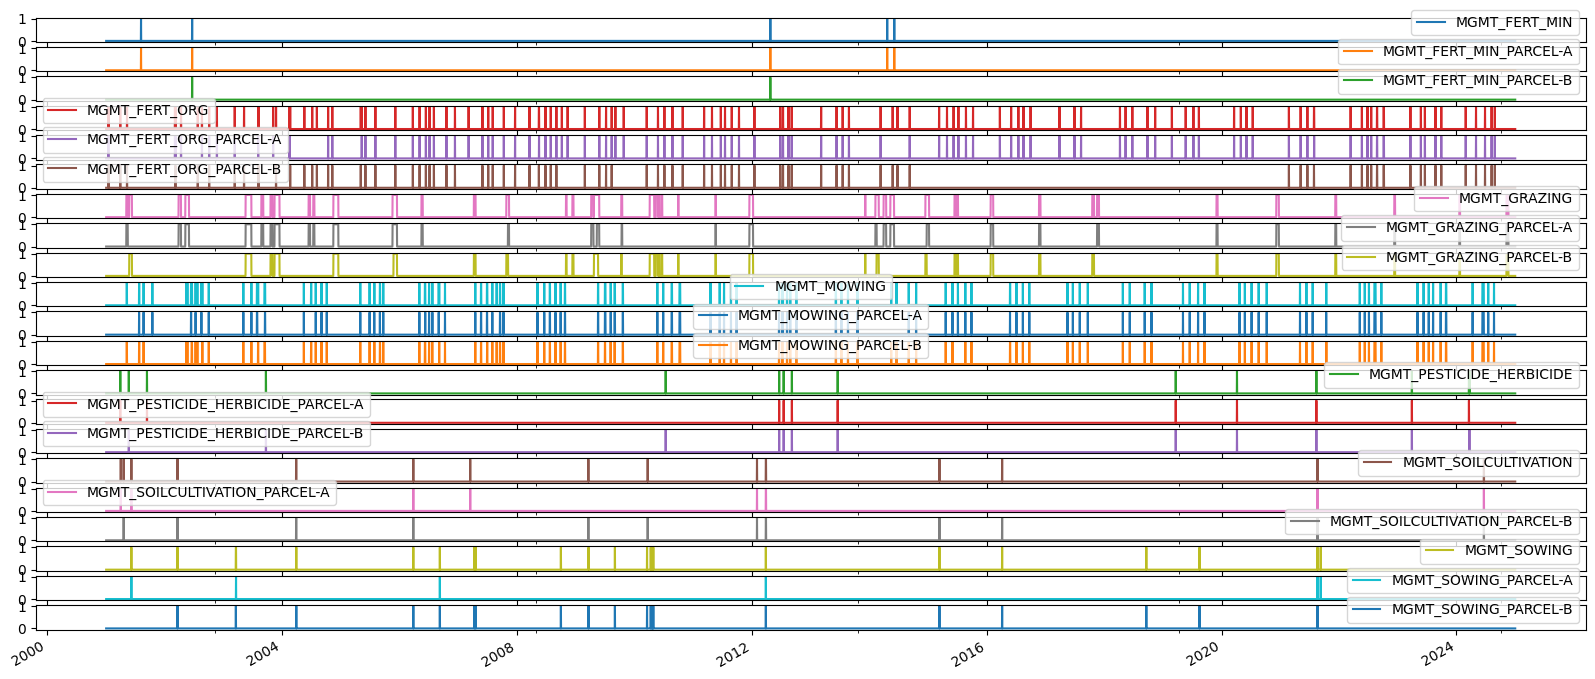

In [30]:
mgmt_daily.plot(x_compat=True, subplots=True, figsize=(20, 9));

## Calculate `TIMESINCE` management event

In [31]:
timesincedf = pd.DataFrame()

for v in mgmt_daily.columns:
    series = mgmt_daily[v].squeeze()    
    ts = TimeSince(series, lower_lim=1, include_lim=True)
    ts.calc()
    # ts_full_results = ts.get_full_results()
    timesince = ts.get_timesince()
    timesincedf[timesince.name] = timesince

In [32]:
timesincedf

TIMESINCE_MGMT_FERT_MIN  TIMESINCE_MGMT_FERT_MIN_PARCEL-A  TIMESINCE_MGMT_FERT_MIN_PARCEL-B  TIMESINCE_MGMT_FERT_ORG  TIMESINCE_MGMT_FERT_ORG_PARCEL-A  TIMESINCE_MGMT_FERT_ORG_PARCEL-B  TIMESINCE_MGMT_GRAZING  TIMESINCE_MGMT_GRAZING_PARCEL-A  TIMESINCE_MGMT_GRAZING_PARCEL-B  TIMESINCE_MGMT_MOWING  TIMESINCE_MGMT_MOWING_PARCEL-A  TIMESINCE_MGMT_MOWING_PARCEL-B  TIMESINCE_MGMT_PESTICIDE_HERBICIDE  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B  TIMESINCE_MGMT_SOILCULTIVATION  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B  TIMESINCE_MGMT_SOWING  TIMESINCE_MGMT_SOWING_PARCEL-A  TIMESINCE_MGMT_SOWING_PARCEL-B
2001-01-01                        1                                 1                                 1                        1                                 1                                 1                       1                                1                                1                      1                               1                               1                                   1                                            1                                            1                               1                                        1                                        1                      1                               1                               1
2001-01-02                        2                                 2                                 2                        2                                 2                                 2                       2                                2                                2                      2                               2                               2                                   2                                            2                                            2                               2                                        2                                        2                      2                               2                               2
2001-01-03                        3                                 3                                 3                        3                                 3                                 3                       3                                3                                3                      3                               3                               3                                   3                                            3                                            3                               3                                        3                                        3                      3                               3                               3
2001-01-04                        4                                 4                                 4                        4                                 4                                 4                       4                                4                                4                      4                               4                               4                                   4                                            4                                            4                               4                                        4                                        4                      4                               4                               4
2001-01-05                        5                                 5                                 5                        5                                 5                                 5                       5                                5                                5                      5                               5                               5                                   5                                            5                                            5        

### Plots

C:\Users\nopan\AppData\Local\Temp\ipykernel_20820\448018422.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='white', figsize=(40, 4), dpi=100, layout='constrained')
C:\Users\nopan\miniconda3\envs\cha_fp2024\Lib\site-packages\IPython\core\events.py:82: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
C:\Users\nopan\miniconda3\envs\cha_fp2024\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


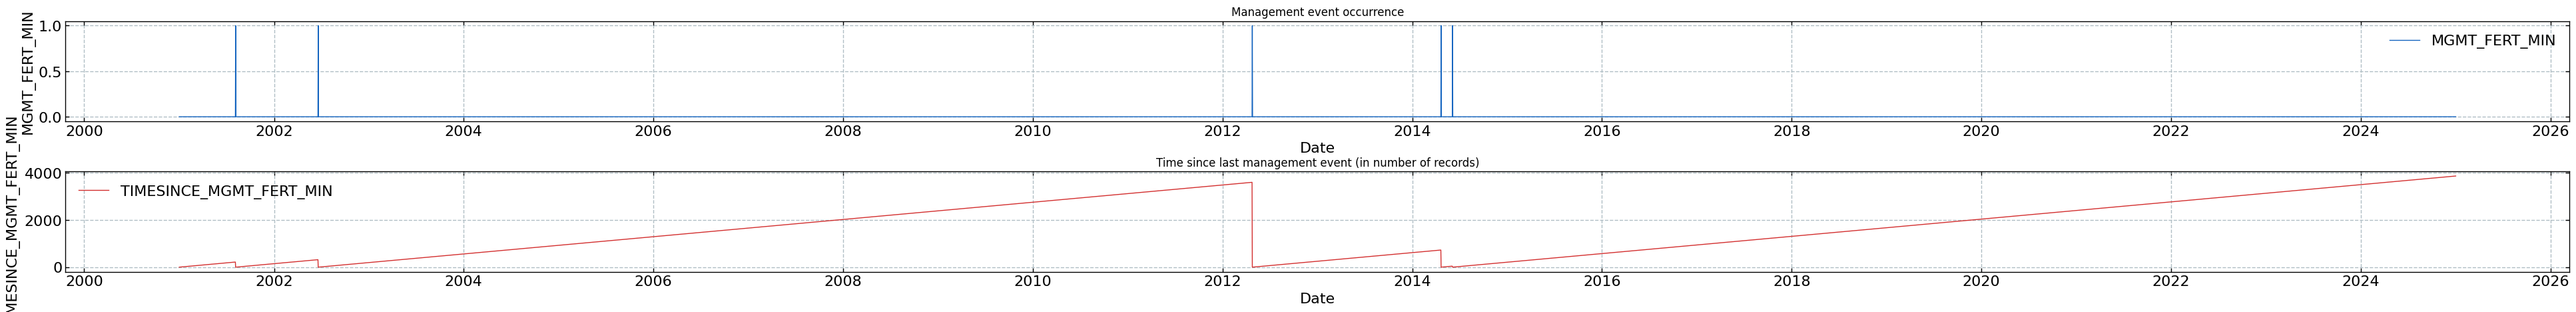

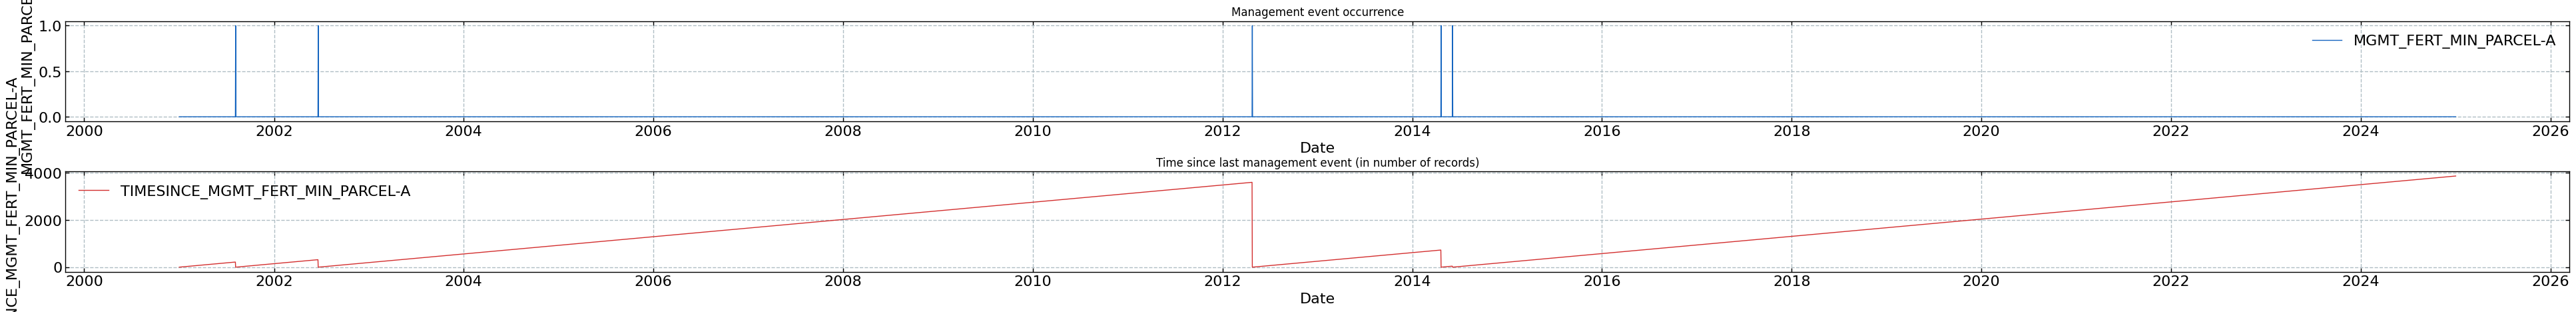

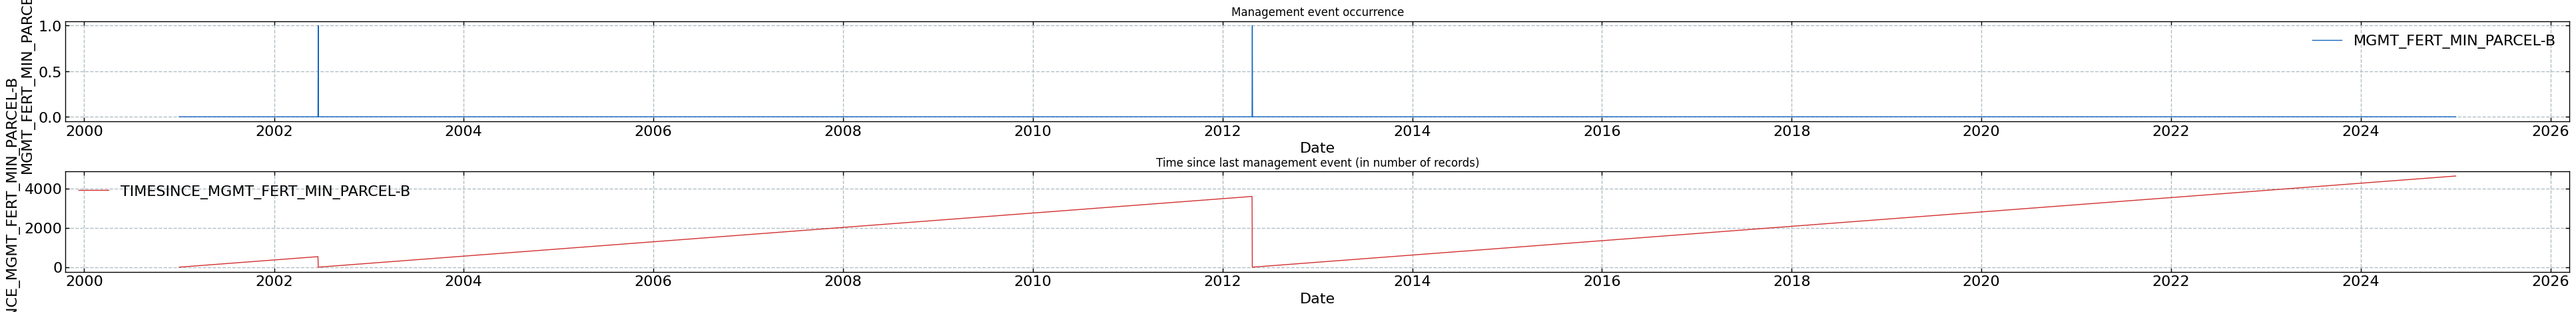

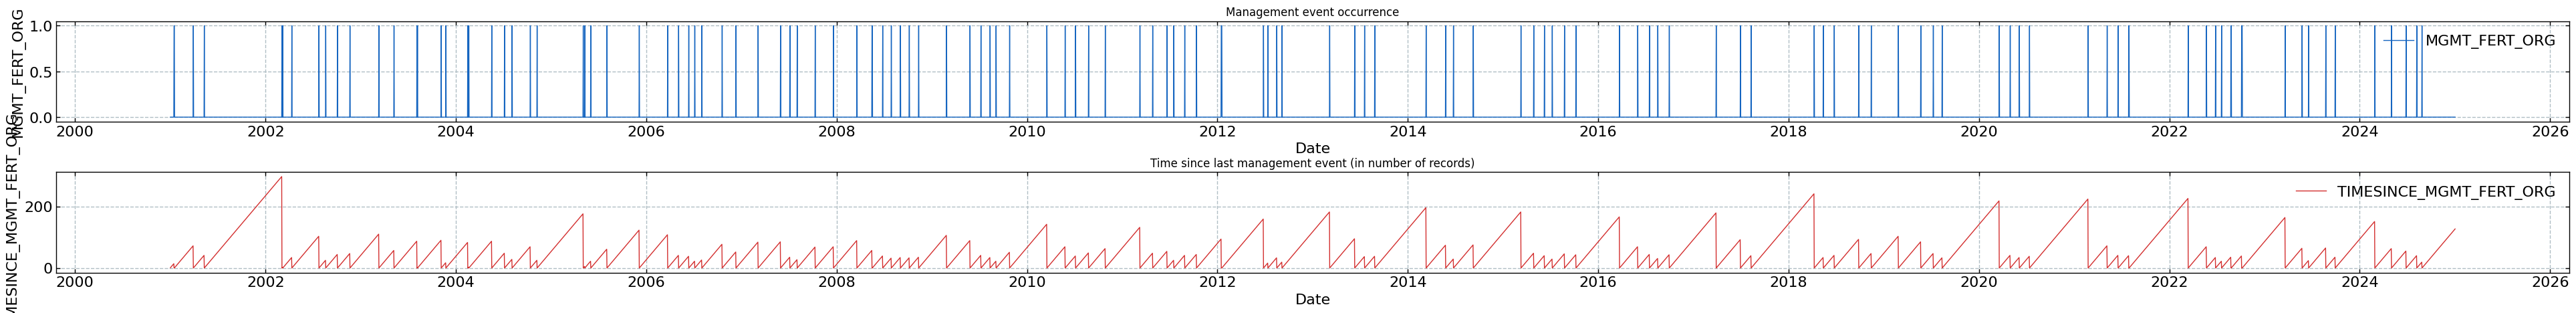

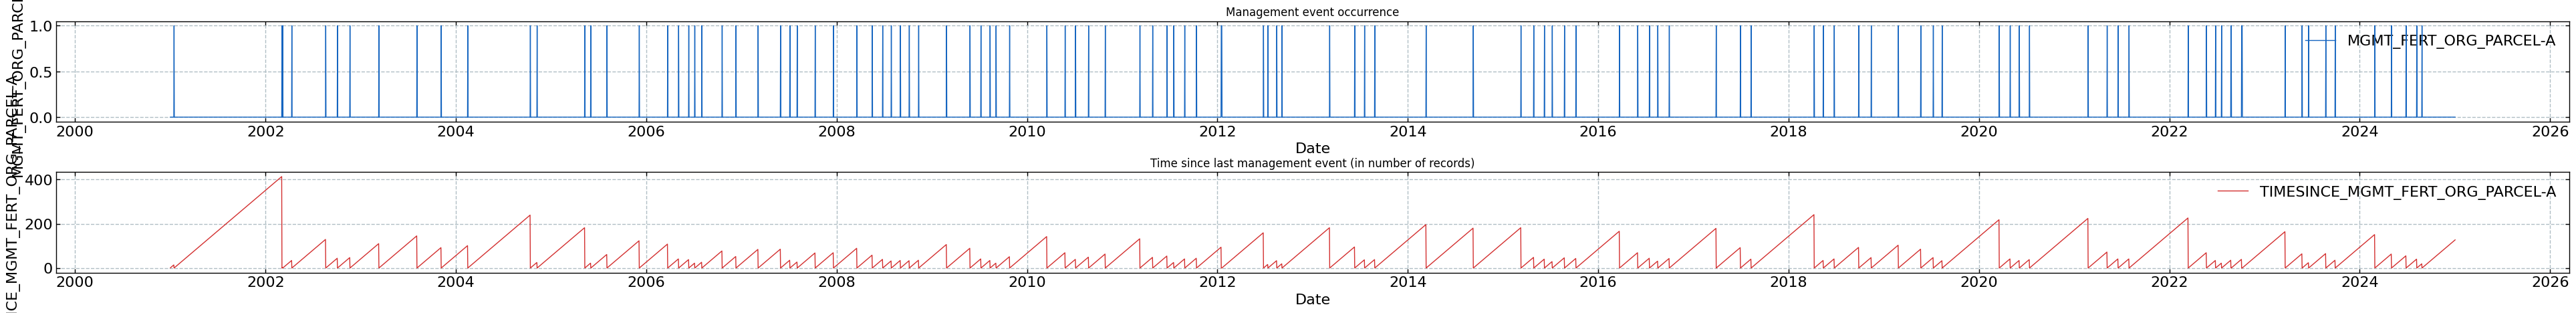

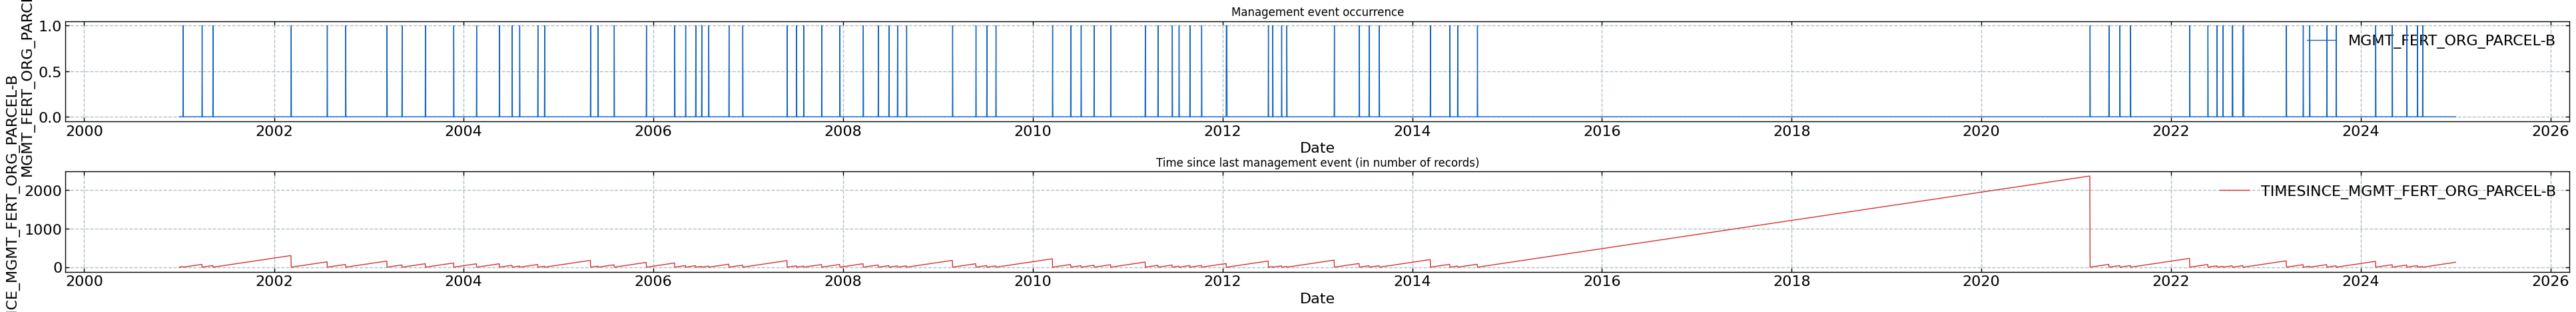

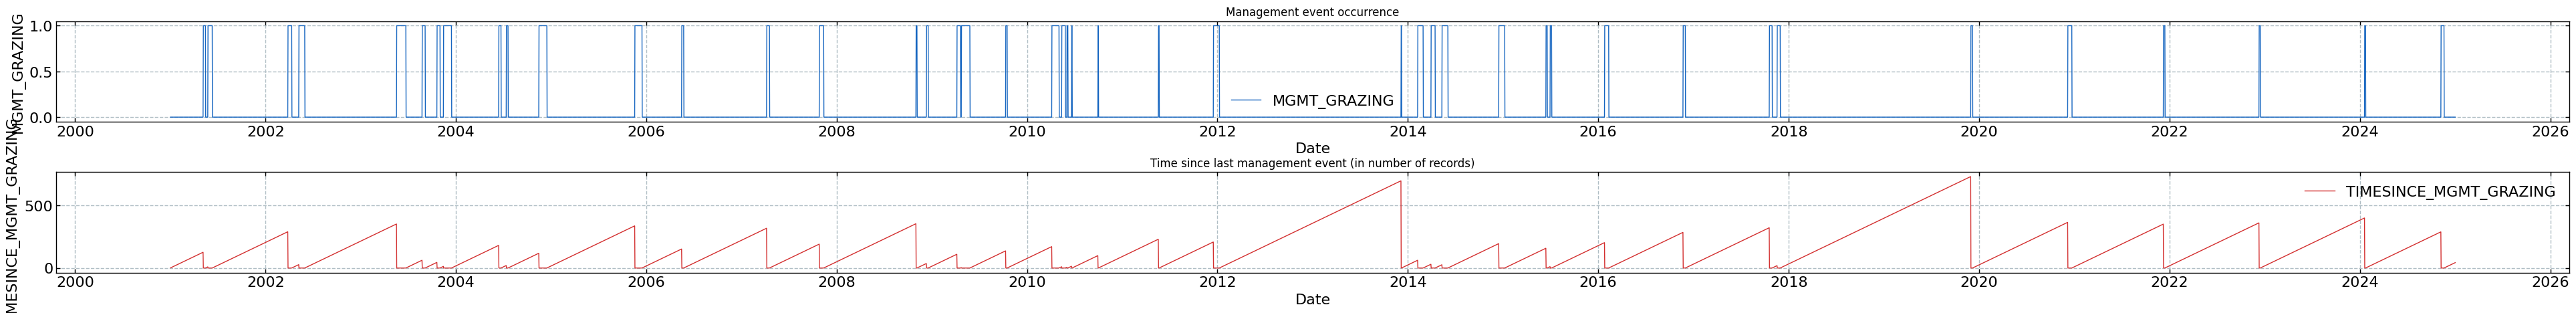

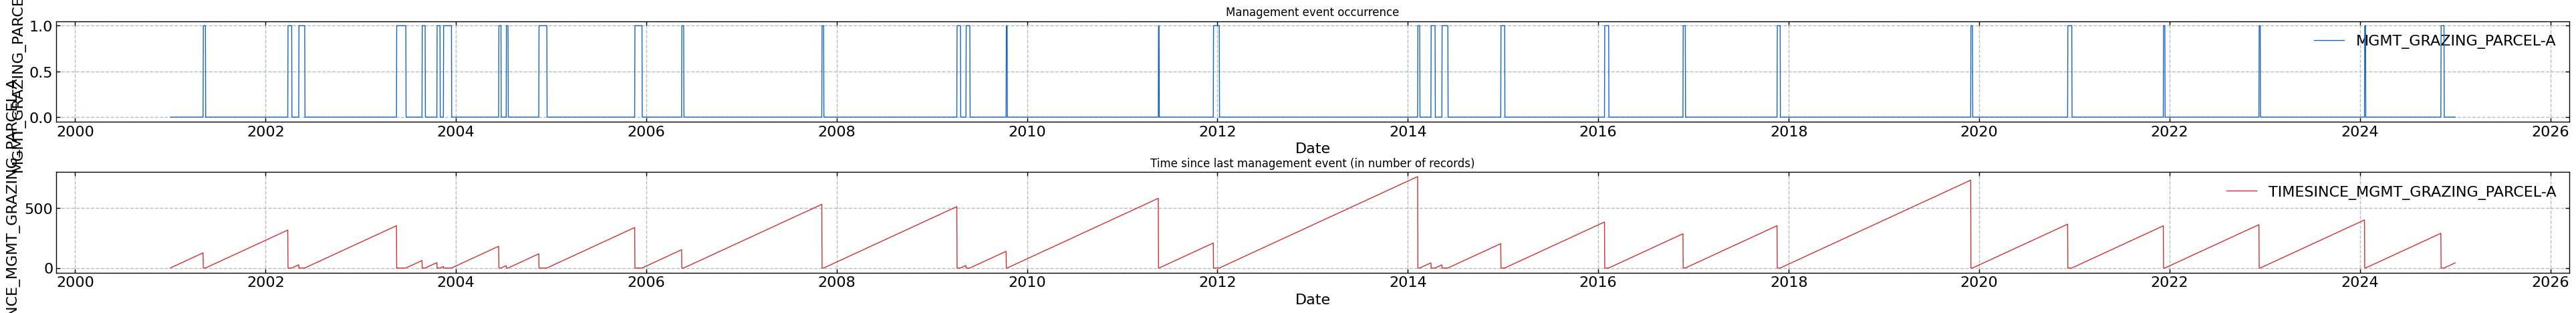

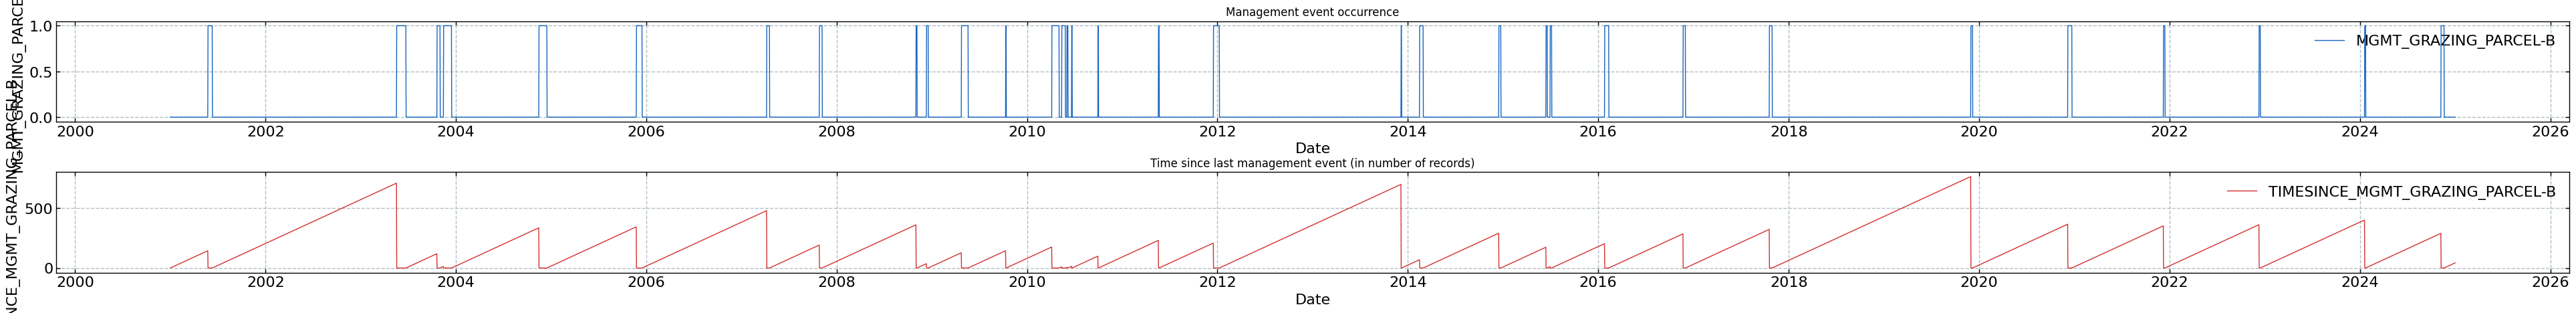

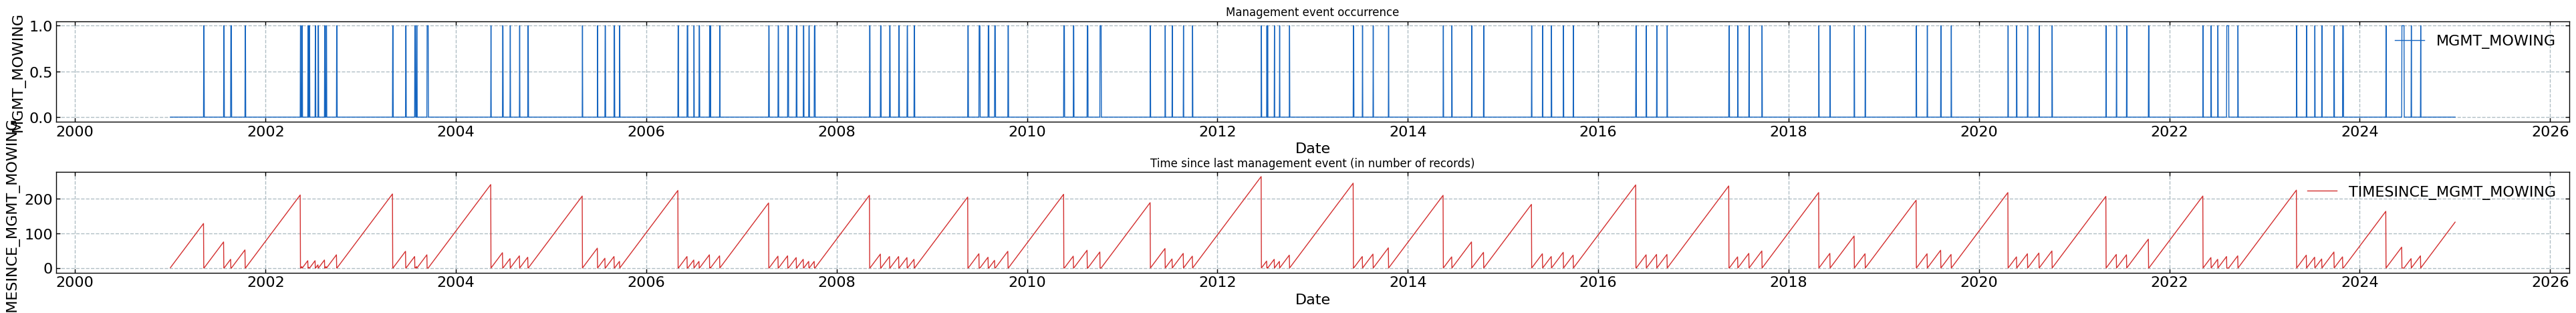

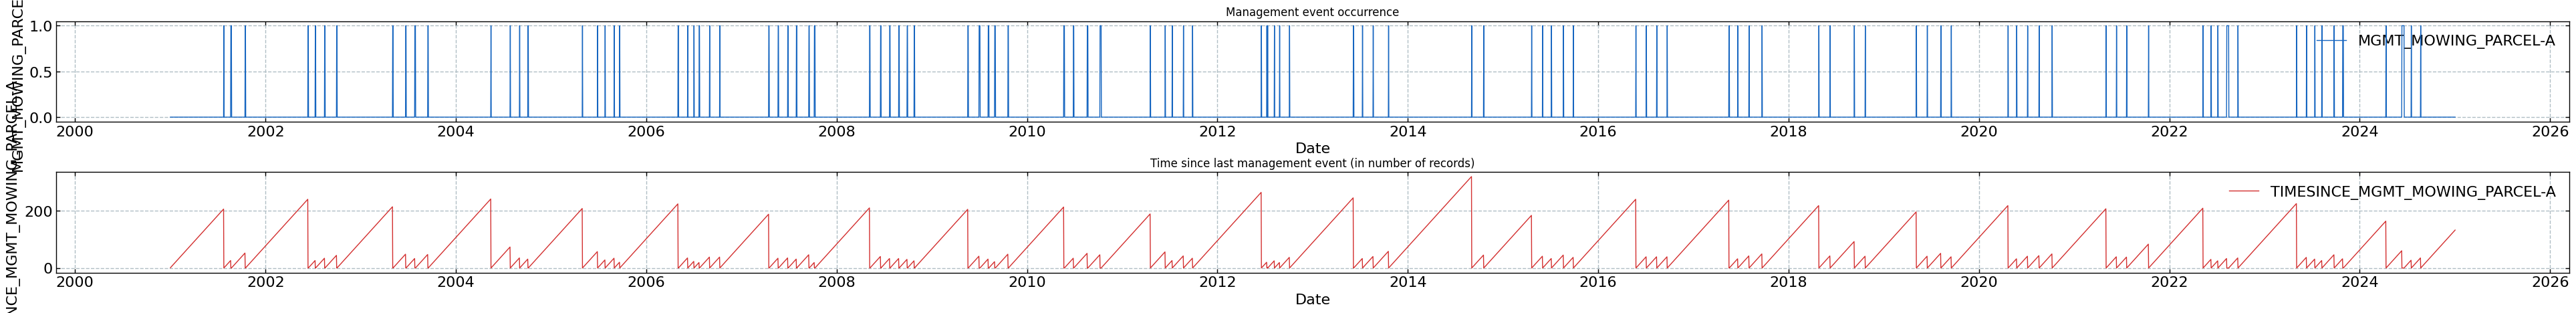

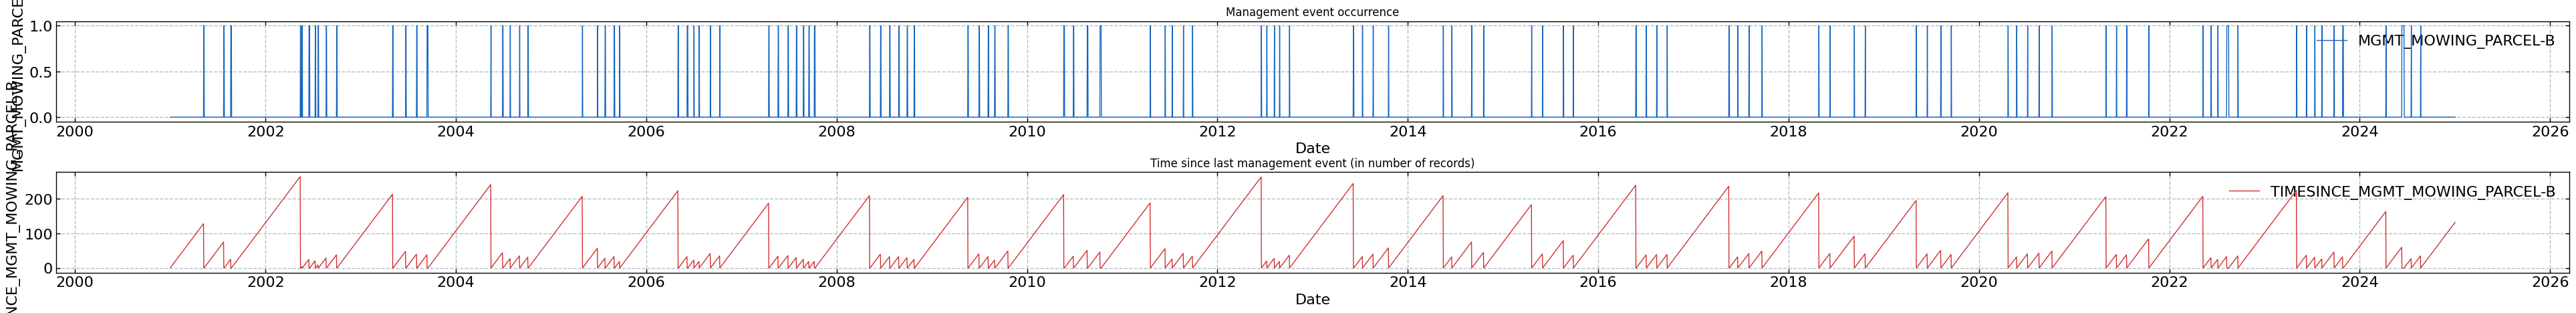

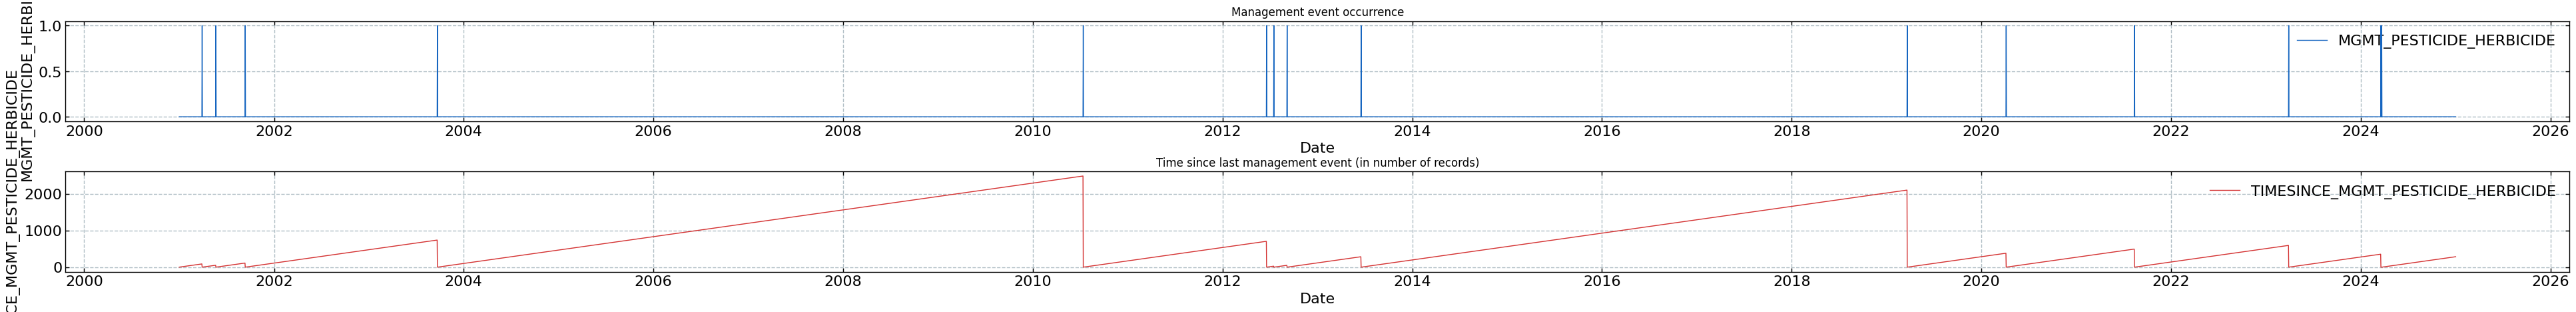

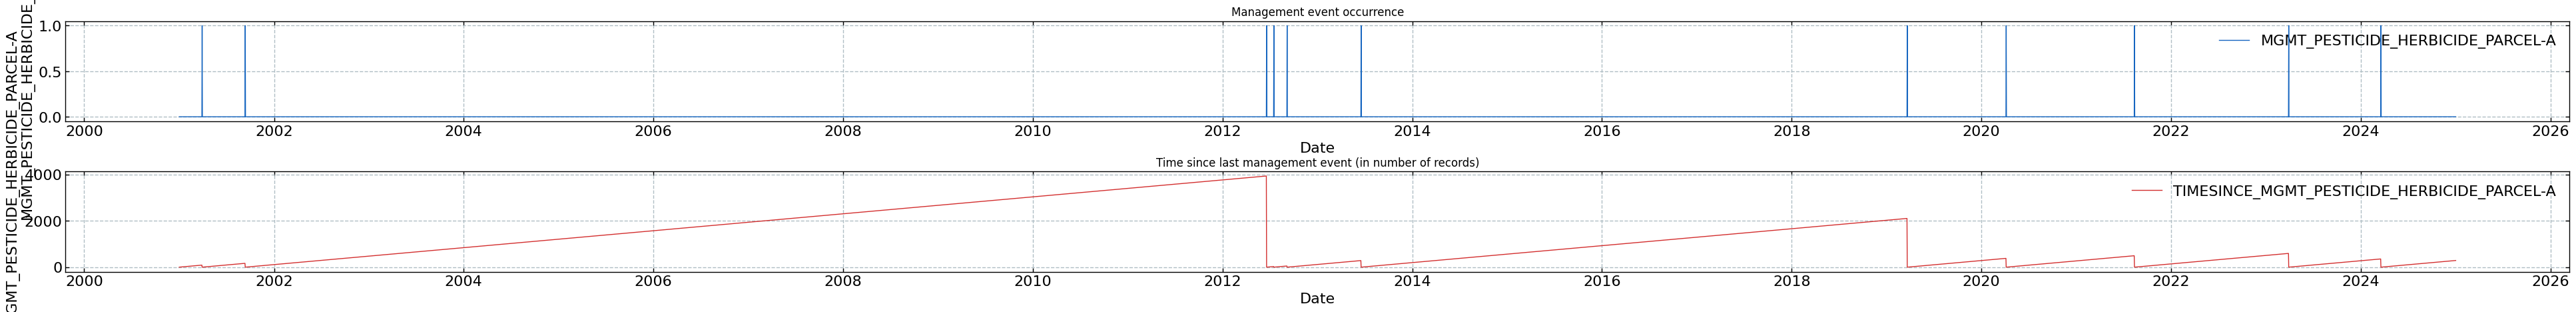

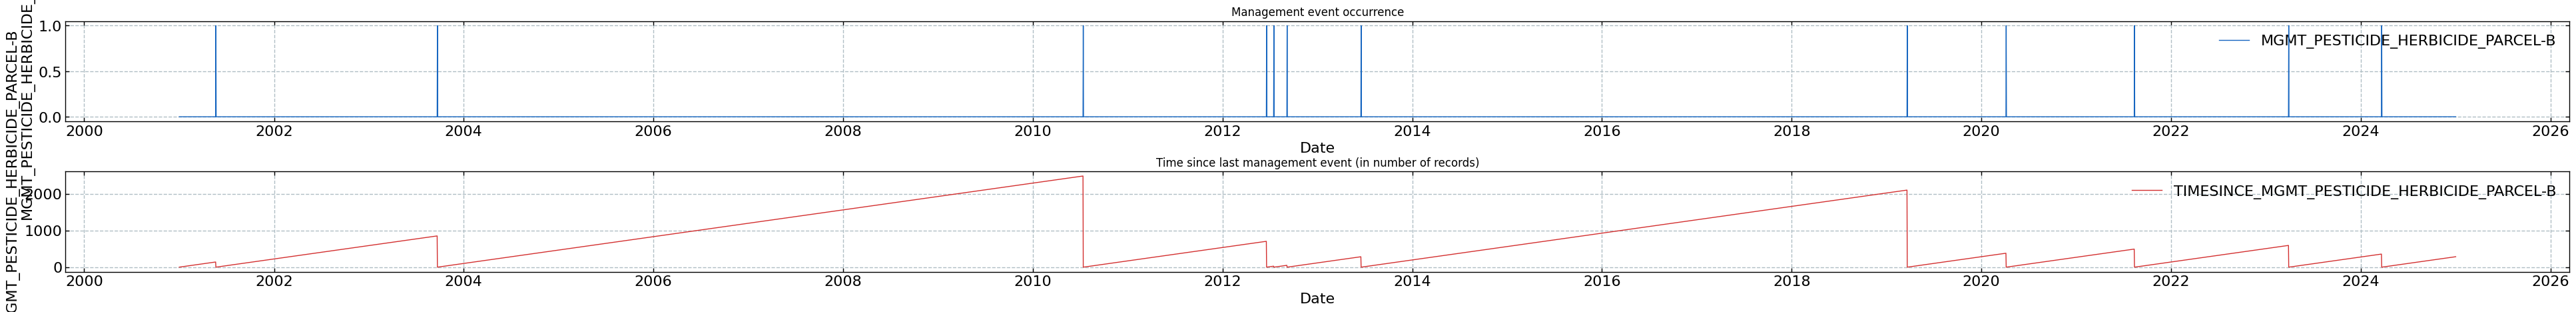

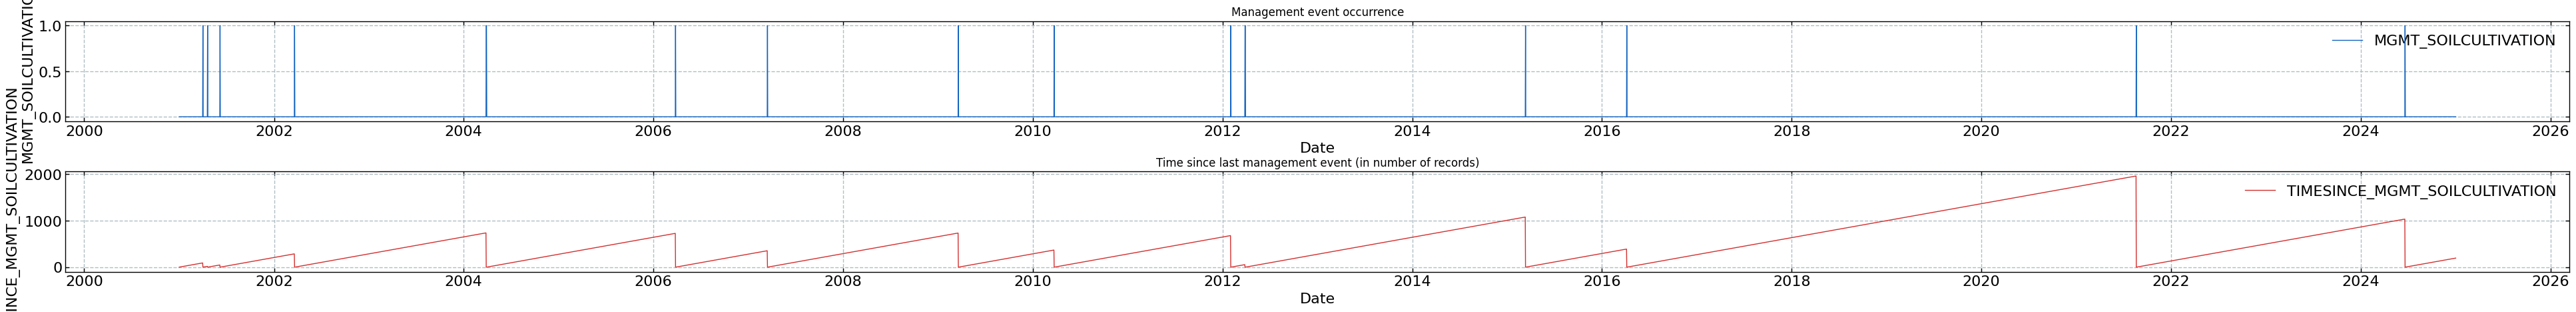

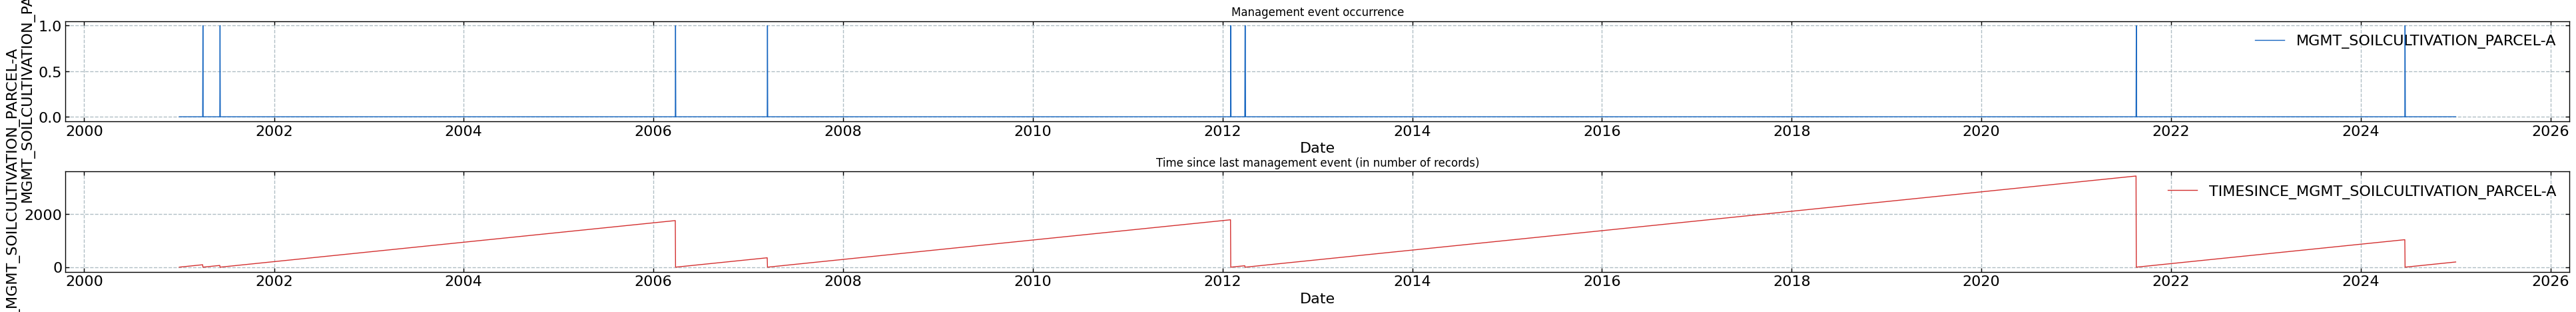

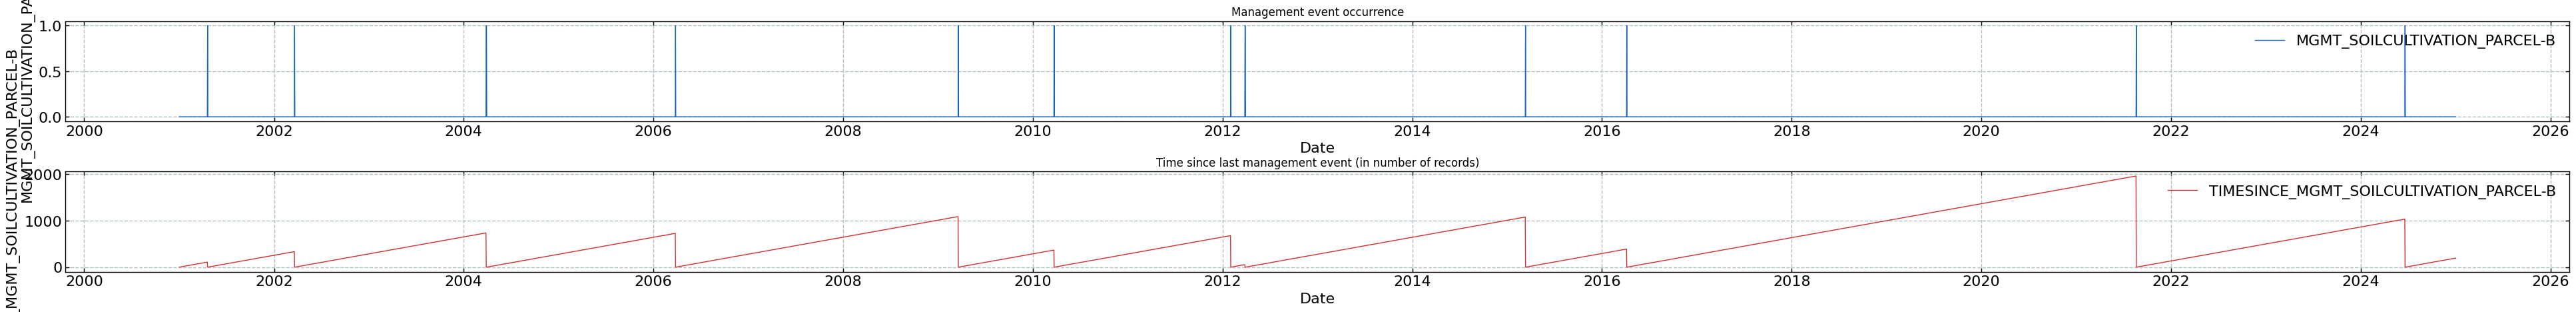

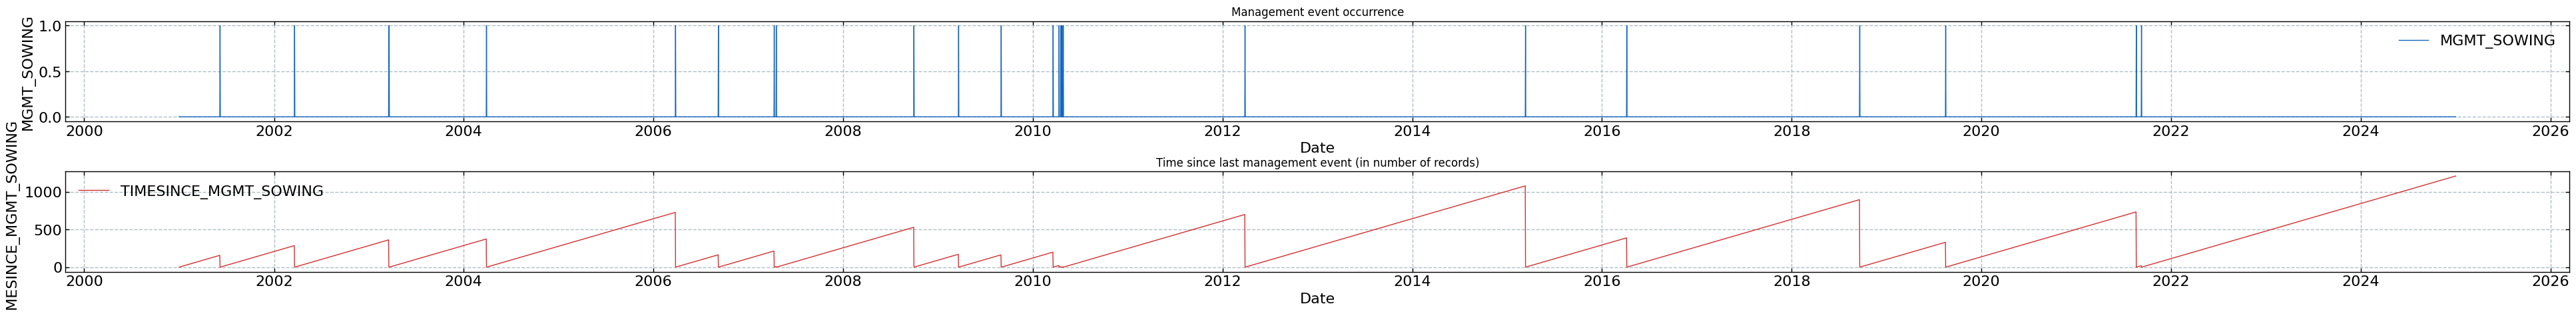

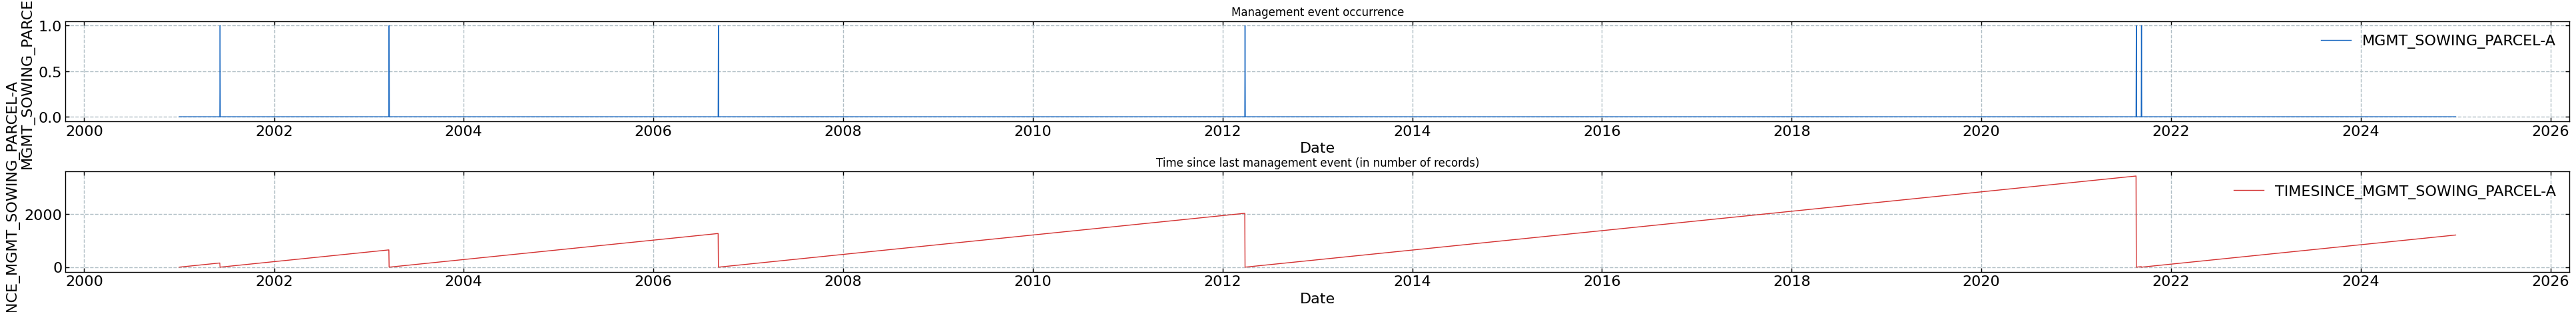

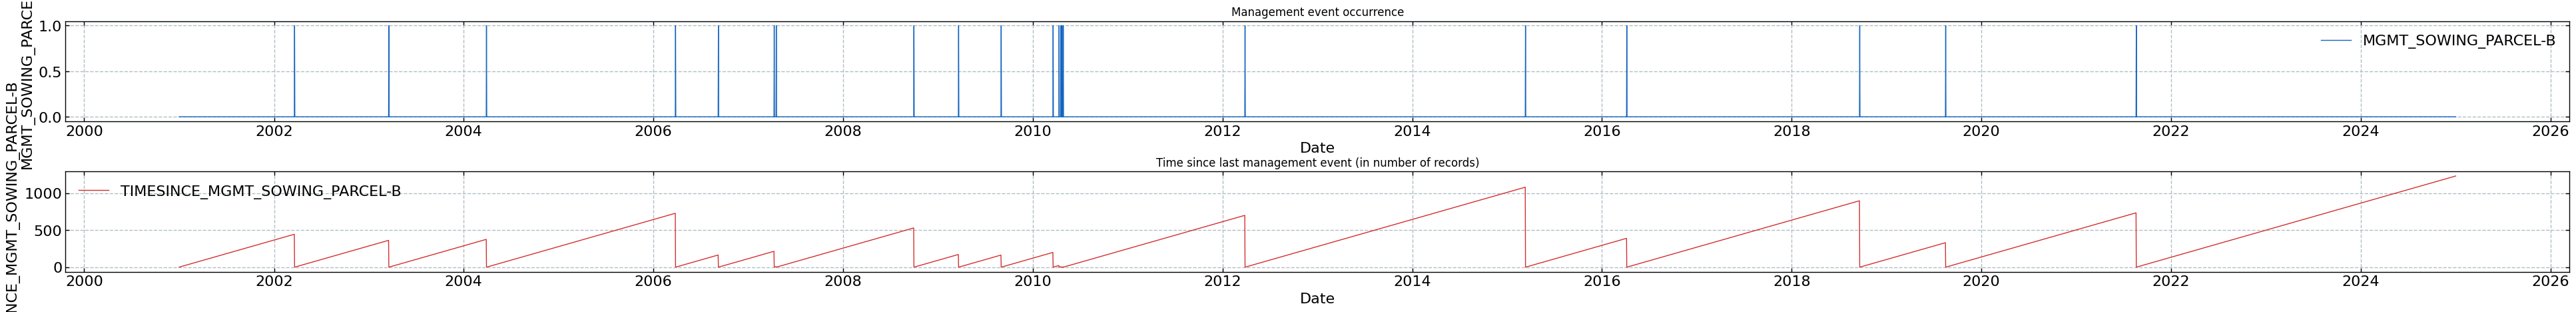

In [33]:
for v in mgmt_daily.columns:
    fig = plt.figure(facecolor='white', figsize=(40, 4), dpi=100, layout='constrained')
    gs = gridspec.GridSpec(2, 1)  # rows, cols
    gs.update(wspace=0.3, hspace=.5, left=0.03, right=0.97, top=0.97, bottom=0.03)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    TimeSeries(ax=ax1, series=mgmt_daily[v]).plot(color='#1565C0')
    TimeSeries(ax=ax2, series=timesincedf[f'TIMESINCE_{v}']).plot(color='#D32F2F')
    ax1.set_title("Management event occurrence", color='black')
    ax2.set_title("Time since last management event (in number of records)", color='black')    

## + Add `TIMESINCE` variables to management data

In [34]:
mgmt_daily = pd.concat([mgmt_daily, timesincedf], axis=1)
mgmt_daily

MGMT_FERT_MIN  MGMT_FERT_MIN_PARCEL-A  MGMT_FERT_MIN_PARCEL-B  MGMT_FERT_ORG  MGMT_FERT_ORG_PARCEL-A  MGMT_FERT_ORG_PARCEL-B  MGMT_GRAZING  MGMT_GRAZING_PARCEL-A  MGMT_GRAZING_PARCEL-B  MGMT_MOWING  MGMT_MOWING_PARCEL-A  MGMT_MOWING_PARCEL-B  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-A  MGMT_PESTICIDE_HERBICIDE_PARCEL-B  ...  TIMESINCE_MGMT_GRAZING  TIMESINCE_MGMT_GRAZING_PARCEL-A  TIMESINCE_MGMT_GRAZING_PARCEL-B  TIMESINCE_MGMT_MOWING  TIMESINCE_MGMT_MOWING_PARCEL-A  TIMESINCE_MGMT_MOWING_PARCEL-B  TIMESINCE_MGMT_PESTICIDE_HERBICIDE  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B  TIMESINCE_MGMT_SOILCULTIVATION  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B  TIMESINCE_MGMT_SOWING  TIMESINCE_MGMT_SOWING_PARCEL-A  TIMESINCE_MGMT_SOWING_PARCEL-B
2001-01-01            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                       1                                1                                1                      1                               1                               1                                   1                                            1                                            1                               1                                        1                                        1                      1                               1                               1
2001-01-02            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                       2                                2                                2                      2                               2                               2                                   2                                            2                                            2                               2                                        2                                        2                      2                               2                               2
2001-01-03            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                       3                                3                                3                      3                               3                               3                                   3                                            3                                            3                               3                                        3                                        3                      3                               3                               3
2001-01-04            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                       4                                4                                4                      4                               4                               4                                   4         

In [35]:
collist = mgmt_daily.columns.tolist()
collist

['MGMT_FERT_MIN',
 'MGMT_FERT_MIN_PARCEL-A',
 'MGMT_FERT_MIN_PARCEL-B',
 'MGMT_FERT_ORG',
 'MGMT_FERT_ORG_PARCEL-A',
 'MGMT_FERT_ORG_PARCEL-B',
 'MGMT_GRAZING',
 'MGMT_GRAZING_PARCEL-A',
 'MGMT_GRAZING_PARCEL-B',
 'MGMT_MOWING',
 'MGMT_MOWING_PARCEL-A',
 'MGMT_MOWING_PARCEL-B',
 'MGMT_PESTICIDE_HERBICIDE',
 'MGMT_PESTICIDE_HERBICIDE_PARCEL-A',
 'MGMT_PESTICIDE_HERBICIDE_PARCEL-B',
 'MGMT_SOILCULTIVATION',
 'MGMT_SOILCULTIVATION_PARCEL-A',
 'MGMT_SOILCULTIVATION_PARCEL-B',
 'MGMT_SOWING',
 'MGMT_SOWING_PARCEL-A',
 'MGMT_SOWING_PARCEL-B',
 'TIMESINCE_MGMT_FERT_MIN',
 'TIMESINCE_MGMT_FERT_MIN_PARCEL-A',
 'TIMESINCE_MGMT_FERT_MIN_PARCEL-B',
 'TIMESINCE_MGMT_FERT_ORG',
 'TIMESINCE_MGMT_FERT_ORG_PARCEL-A',
 'TIMESINCE_MGMT_FERT_ORG_PARCEL-B',
 'TIMESINCE_MGMT_GRAZING',
 'TIMESINCE_MGMT_GRAZING_PARCEL-A',
 'TIMESINCE_MGMT_GRAZING_PARCEL-B',
 'TIMESINCE_MGMT_MOWING',
 'TIMESINCE_MGMT_MOWING_PARCEL-A',
 'TIMESINCE_MGMT_MOWING_PARCEL-B',
 'TIMESINCE_MGMT_PESTICIDE_HERBICIDE',
 'TIMESINCE_MGMT_PE

In [36]:
mgmt_daily.to_csv("22.4_mgmt_daily.csv")

</br>

</br>

---

# **HALF-HOURLY**

---

## Initiate footprint management columns

In [37]:
mgmt_cols = [sub.replace('_PARCEL-A', '') for sub in collist]
mgmt_cols = [sub.replace('_PARCEL-B', '') for sub in mgmt_cols]
mgmt_cols = [sub.replace('TIMESINCE_', '') for sub in mgmt_cols]
mgmt_cols = list(set(mgmt_cols))
display(mgmt_cols)

['MGMT_PESTICIDE_HERBICIDE',
 'MGMT_GRAZING',
 'MGMT_SOILCULTIVATION',
 'MGMT_SOWING',
 'MGMT_FERT_ORG',
 'MGMT_FERT_MIN',
 'MGMT_MOWING']

In [38]:
fp_mgmt_cols = [f"{c}_FOOTPRINT" for c in mgmt_cols]
fp_mgmt_cols

['MGMT_PESTICIDE_HERBICIDE_FOOTPRINT',
 'MGMT_GRAZING_FOOTPRINT',
 'MGMT_SOILCULTIVATION_FOOTPRINT',
 'MGMT_SOWING_FOOTPRINT',
 'MGMT_FERT_ORG_FOOTPRINT',
 'MGMT_FERT_MIN_FOOTPRINT',
 'MGMT_MOWING_FOOTPRINT']

In [39]:
# Add empty footprint columns to dataframe
mgmt_daily = mgmt_daily.reindex(columns = mgmt_daily.columns.tolist() + fp_mgmt_cols)
mgmt_daily

MGMT_FERT_MIN  MGMT_FERT_MIN_PARCEL-A  MGMT_FERT_MIN_PARCEL-B  MGMT_FERT_ORG  MGMT_FERT_ORG_PARCEL-A  MGMT_FERT_ORG_PARCEL-B  MGMT_GRAZING  MGMT_GRAZING_PARCEL-A  MGMT_GRAZING_PARCEL-B  MGMT_MOWING  MGMT_MOWING_PARCEL-A  MGMT_MOWING_PARCEL-B  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-A  MGMT_PESTICIDE_HERBICIDE_PARCEL-B  ...  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B  TIMESINCE_MGMT_SOILCULTIVATION  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B  TIMESINCE_MGMT_SOWING  TIMESINCE_MGMT_SOWING_PARCEL-A  TIMESINCE_MGMT_SOWING_PARCEL-B  MGMT_PESTICIDE_HERBICIDE_FOOTPRINT  MGMT_GRAZING_FOOTPRINT  MGMT_SOILCULTIVATION_FOOTPRINT  MGMT_SOWING_FOOTPRINT  MGMT_FERT_ORG_FOOTPRINT  MGMT_FERT_MIN_FOOTPRINT  MGMT_MOWING_FOOTPRINT
2001-01-01            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            1                                            1                               1                                        1                                        1                      1                               1                               1                                 NaN                     NaN                             NaN                    NaN                      NaN                      NaN                    NaN
2001-01-02            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            2                                            2                               2                                        2                                        2                      2                               2                               2                                 NaN                     NaN                             NaN                    NaN                      NaN                      NaN                    NaN
2001-01-03            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            3                                            3                               3                                        3                                        3                      3                               3                               3                                 NaN                     NaN                             NaN                    NaN                      NaN                      NaN                    NaN
2001-01-04            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            4                                            4                               4                                        4                                        4                      4                               4                               4                               

## Half-hourly timestamp for management data

In [40]:
first_hh = pd.to_datetime(mgmt_daily.index[0]) + pd.Timedelta(minutes=15)
last_hh = pd.to_datetime(mgmt_daily.index[-1]) + pd.Timedelta(hours=23, minutes=45)
print(first_hh)
print(last_hh)

2001-01-01 00:15:00
2025-01-01 23:45:00


## Create half-hourly dataframe for management data

In [41]:
timestamp_hh = pd.date_range(first_hh, last_hh, freq='30min')
mgmt_hh = pd.DataFrame(index=timestamp_hh)
mgmt_hh['TIMESTAMP_MIDDLE'] = pd.to_datetime(mgmt_hh.index)  # For merging with daily time resolution management data
mgmt_hh['DATE'] = pd.to_datetime(mgmt_hh.index.date)  # For merging with daily time resolution management data
mgmt_hh

TIMESTAMP_MIDDLE       DATE
2001-01-01 00:15:00 2001-01-01 00:15:00 2001-01-01
2001-01-01 00:45:00 2001-01-01 00:45:00 2001-01-01
2001-01-01 01:15:00 2001-01-01 01:15:00 2001-01-01
2001-01-01 01:45:00 2001-01-01 01:45:00 2001-01-01
2001-01-01 02:15:00 2001-01-01 02:15:00 2001-01-01
...                                 ...        ...
2025-01-01 21:45:00 2025-01-01 21:45:00 2025-01-01
2025-01-01 22:15:00 2025-01-01 22:15:00 2025-01-01
2025-01-01 22:45:00 2025-01-01 22:45:00 2025-01-01
2025-01-01 23:15:00 2025-01-01 23:15:00 2025-01-01
2025-01-01 23:45:00 2025-01-01 23:45:00 2025-01-01

[420816 rows x 2 columns]

In [42]:
mgmt_daily['DATE'] = mgmt_daily.index
mgmt_daily['DATE'] = pd.to_datetime(mgmt_daily['DATE'])
mgmt_daily.head(3)

MGMT_FERT_MIN  MGMT_FERT_MIN_PARCEL-A  MGMT_FERT_MIN_PARCEL-B  MGMT_FERT_ORG  MGMT_FERT_ORG_PARCEL-A  MGMT_FERT_ORG_PARCEL-B  MGMT_GRAZING  MGMT_GRAZING_PARCEL-A  MGMT_GRAZING_PARCEL-B  MGMT_MOWING  MGMT_MOWING_PARCEL-A  MGMT_MOWING_PARCEL-B  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-A  MGMT_PESTICIDE_HERBICIDE_PARCEL-B  ...  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B  TIMESINCE_MGMT_SOILCULTIVATION  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B  TIMESINCE_MGMT_SOWING  TIMESINCE_MGMT_SOWING_PARCEL-A  TIMESINCE_MGMT_SOWING_PARCEL-B  MGMT_PESTICIDE_HERBICIDE_FOOTPRINT  MGMT_GRAZING_FOOTPRINT  MGMT_SOILCULTIVATION_FOOTPRINT  MGMT_SOWING_FOOTPRINT  MGMT_FERT_ORG_FOOTPRINT  MGMT_FERT_MIN_FOOTPRINT  MGMT_MOWING_FOOTPRINT       DATE
2001-01-01            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            1                               1                                        1                                        1                      1                               1                               1                                 NaN                     NaN                             NaN                    NaN                      NaN                      NaN                    NaN 2001-01-01
2001-01-02            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            2                               2                                        2                                        2                      2                               2                               2                                 NaN                     NaN                             NaN                    NaN                      NaN                      NaN                    NaN 2001-01-02
2001-01-03            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            3                               3                                        3                                        3                      3                               3                               3                                 NaN                     NaN                             NaN                    NaN                      NaN                      NaN                    NaN 2001-01-03

[3 rows x 50 columns]

In [43]:
# Merge on DATE column
mgmt_hh = pd.merge(mgmt_hh, mgmt_daily, on='DATE')
mgmt_hh = mgmt_hh.set_index('TIMESTAMP_MIDDLE')
mgmt_hh = mgmt_hh.drop('DATE', axis=1)
mgmt_hh

MGMT_FERT_MIN  MGMT_FERT_MIN_PARCEL-A  MGMT_FERT_MIN_PARCEL-B  MGMT_FERT_ORG  MGMT_FERT_ORG_PARCEL-A  MGMT_FERT_ORG_PARCEL-B  MGMT_GRAZING  MGMT_GRAZING_PARCEL-A  MGMT_GRAZING_PARCEL-B  MGMT_MOWING  MGMT_MOWING_PARCEL-A  MGMT_MOWING_PARCEL-B  MGMT_PESTICIDE_HERBICIDE  MGMT_PESTICIDE_HERBICIDE_PARCEL-A  MGMT_PESTICIDE_HERBICIDE_PARCEL-B  ...  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B  TIMESINCE_MGMT_SOILCULTIVATION  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B  TIMESINCE_MGMT_SOWING  TIMESINCE_MGMT_SOWING_PARCEL-A  TIMESINCE_MGMT_SOWING_PARCEL-B  MGMT_PESTICIDE_HERBICIDE_FOOTPRINT  MGMT_GRAZING_FOOTPRINT  MGMT_SOILCULTIVATION_FOOTPRINT  MGMT_SOWING_FOOTPRINT  MGMT_FERT_ORG_FOOTPRINT  MGMT_FERT_MIN_FOOTPRINT  MGMT_MOWING_FOOTPRINT
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                                        ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2001-01-01 00:15:00            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            1                                            1                               1                                        1                                        1                      1                               1                               1                                 NaN                     NaN                             NaN                    NaN                      NaN                      NaN                    NaN
2001-01-01 00:45:00            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            1                                            1                               1                                        1                                        1                      1                               1                               1                                 NaN                     NaN                             NaN                    NaN                      NaN                      NaN                    NaN
2001-01-01 01:15:00            0.0                       0                       0            0.0                       0                       0           0.0                      0                      0          0.0                     0                     0                       0.0                                  0                                  0  ...                                            1                                            1                               1                                        1                                        1                      1                               1                           

## + Add wind direction to management data

In [44]:
mgmt_hh['WD'] = winddir.copy()
mgmt_hh['WD']

TIMESTAMP_MIDDLE
2001-01-01 00:15:00   NaN
2001-01-01 00:45:00   NaN
2001-01-01 01:15:00   NaN
2001-01-01 01:45:00   NaN
2001-01-01 02:15:00   NaN
                       ..
2025-01-01 21:45:00   NaN
2025-01-01 22:15:00   NaN
2025-01-01 22:45:00   NaN
2025-01-01 23:15:00   NaN
2025-01-01 23:45:00   NaN
Name: WD, Length: 420816, dtype: float64

## List of managments in half-hourly dataframe

In [45]:
mgmt_hh_cols = mgmt_hh.columns.to_list()
mgmt_hh_cols = [sub.replace('_PARCEL-A', '') for sub in mgmt_hh_cols]
mgmt_hh_cols = [sub.replace('_PARCEL-B', '') for sub in mgmt_hh_cols]
mgmt_hh_cols = [sub.replace('TIMESINCE_', '') for sub in mgmt_hh_cols]
mgmt_hh_cols = [sub.replace('_FOOTPRINT', '') for sub in mgmt_hh_cols]
mgmt_hh_cols.remove("WD")
mgmt_hh_cols = list(set(mgmt_hh_cols))
mgmt_hh_cols

['MGMT_PESTICIDE_HERBICIDE',
 'MGMT_GRAZING',
 'MGMT_SOILCULTIVATION',
 'MGMT_SOWING',
 'MGMT_FERT_ORG',
 'MGMT_FERT_MIN',
 'MGMT_MOWING']

## Fill footprint management columns depending on wind direction

- Parcel division runs from 250° to 70°
- Parcel A (south of station): >= 70, < 250
- Parcel B (north of station: )>= 250, < 70

In [46]:
locs_parcel_a = (mgmt_hh['WD'] >= 70) & (mgmt_hh['WD'] < 250)  # parcel south of station
locs_parcel_b = (mgmt_hh['WD'] >= 250) | (mgmt_hh['WD'] < 70)  # parcel north of station

for m in mgmt_hh_cols:    
    fp_var = f"{m}_FOOTPRINT"
    fp_timesince_var = f"TIMESINCE_{m}_FOOTPRINT"
    
    parcela_var = f"{m}_PARCEL-A"
    if parcela_var in mgmt_hh.columns:        
        parcela_timesince_var = f"TIMESINCE_{m}_PARCEL-A"
        mgmt_hh.loc[locs_parcel_a, fp_var] = mgmt_hh.loc[locs_parcel_a, parcela_var]
        mgmt_hh.loc[locs_parcel_a, fp_timesince_var] = mgmt_hh.loc[locs_parcel_a, parcela_timesince_var]
    
    parcelb_var = f"{m}_PARCEL-B"
    if parcelb_var in mgmt_hh.columns:
        parcelb_timesince_var = f"TIMESINCE_{m}_PARCEL-B"
        mgmt_hh.loc[locs_parcel_b, fp_var] = mgmt_hh.loc[locs_parcel_b, parcelb_var]
        mgmt_hh.loc[locs_parcel_b, fp_timesince_var] = mgmt_hh.loc[locs_parcel_b, parcelb_timesince_var]

## Fill footprint management columns for 2005 (no wind data available)

In [47]:
pd.options.display.max_rows = 4000
mgmt_hh.count()

MGMT_FERT_MIN                                   420816
MGMT_FERT_MIN_PARCEL-A                          420816
MGMT_FERT_MIN_PARCEL-B                          420816
MGMT_FERT_ORG                                   420816
MGMT_FERT_ORG_PARCEL-A                          420816
MGMT_FERT_ORG_PARCEL-B                          420816
MGMT_GRAZING                                    420816
MGMT_GRAZING_PARCEL-A                           420816
MGMT_GRAZING_PARCEL-B                           420816
MGMT_MOWING                                     420816
MGMT_MOWING_PARCEL-A                            420816
MGMT_MOWING_PARCEL-B                            420816
MGMT_PESTICIDE_HERBICIDE                        420816
MGMT_PESTICIDE_HERBICIDE_PARCEL-A               420816
MGMT_PESTICIDE_HERBICIDE_PARCEL-B               420816
MGMT_SOILCULTIVATION                            420816
MGMT_SOILCULTIVATION_PARCEL-A                   420816
MGMT_SOILCULTIVATION_PARCEL-B                   420816
MGMT_SOWIN

In [48]:
for m in mgmt_hh_cols:
    col_to_fill = f"{m}_FOOTPRINT"
    mgmt_hh[col_to_fill] = mgmt_hh[col_to_fill].fillna(mgmt_hh[m])  # Fill missing values in footprint management with general management info (both parcels)
    print(f"Filled missing values in column {col_to_fill} with values from column {m}.")

    col_to_fill_timesince = f"TIMESINCE_{m}_FOOTPRINT"
    m_timesince = f"TIMESINCE_{m}"
    mgmt_hh[col_to_fill_timesince] = mgmt_hh[col_to_fill_timesince].fillna(mgmt_hh[m_timesince])  # Fill missing values in footprint management with general management info (both parcels)
    print(f"Filled missing values in column {col_to_fill_timesince} with values from column {m_timesince}.")

Filled missing values in column MGMT_PESTICIDE_HERBICIDE_FOOTPRINT with values from column MGMT_PESTICIDE_HERBICIDE.
Filled missing values in column TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT with values from column TIMESINCE_MGMT_PESTICIDE_HERBICIDE.
Filled missing values in column MGMT_GRAZING_FOOTPRINT with values from column MGMT_GRAZING.
Filled missing values in column TIMESINCE_MGMT_GRAZING_FOOTPRINT with values from column TIMESINCE_MGMT_GRAZING.
Filled missing values in column MGMT_SOILCULTIVATION_FOOTPRINT with values from column MGMT_SOILCULTIVATION.
Filled missing values in column TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT with values from column TIMESINCE_MGMT_SOILCULTIVATION.
Filled missing values in column MGMT_SOWING_FOOTPRINT with values from column MGMT_SOWING.
Filled missing values in column TIMESINCE_MGMT_SOWING_FOOTPRINT with values from column TIMESINCE_MGMT_SOWING.
Filled missing values in column MGMT_FERT_ORG_FOOTPRINT with values from column MGMT_FERT_ORG.
Fille

In [49]:
pd.options.display.max_rows = 4000
mgmt_hh.isnull().sum()

MGMT_FERT_MIN                                       0
MGMT_FERT_MIN_PARCEL-A                              0
MGMT_FERT_MIN_PARCEL-B                              0
MGMT_FERT_ORG                                       0
MGMT_FERT_ORG_PARCEL-A                              0
MGMT_FERT_ORG_PARCEL-B                              0
MGMT_GRAZING                                        0
MGMT_GRAZING_PARCEL-A                               0
MGMT_GRAZING_PARCEL-B                               0
MGMT_MOWING                                         0
MGMT_MOWING_PARCEL-A                                0
MGMT_MOWING_PARCEL-B                                0
MGMT_PESTICIDE_HERBICIDE                            0
MGMT_PESTICIDE_HERBICIDE_PARCEL-A                   0
MGMT_PESTICIDE_HERBICIDE_PARCEL-B                   0
MGMT_SOILCULTIVATION                                0
MGMT_SOILCULTIVATION_PARCEL-A                       0
MGMT_SOILCULTIVATION_PARCEL-B                       0
MGMT_SOWING                 

## Final half-hourly management dataframe

In [50]:
# Sort columns
mgmt_hh = mgmt_hh.reindex(sorted(mgmt_hh.columns), axis=1)

In [51]:
mgmt_hh

MGMT_FERT_MIN  MGMT_FERT_MIN_FOOTPRINT  MGMT_FERT_MIN_PARCEL-A  MGMT_FERT_MIN_PARCEL-B  MGMT_FERT_ORG  MGMT_FERT_ORG_FOOTPRINT  MGMT_FERT_ORG_PARCEL-A  MGMT_FERT_ORG_PARCEL-B  MGMT_GRAZING  MGMT_GRAZING_FOOTPRINT  MGMT_GRAZING_PARCEL-A  MGMT_GRAZING_PARCEL-B  MGMT_MOWING  MGMT_MOWING_FOOTPRINT  MGMT_MOWING_PARCEL-A  ...  TIMESINCE_MGMT_MOWING_PARCEL-A  TIMESINCE_MGMT_MOWING_PARCEL-B  TIMESINCE_MGMT_PESTICIDE_HERBICIDE  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B  TIMESINCE_MGMT_SOILCULTIVATION  TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B  TIMESINCE_MGMT_SOWING  TIMESINCE_MGMT_SOWING_FOOTPRINT  TIMESINCE_MGMT_SOWING_PARCEL-A  TIMESINCE_MGMT_SOWING_PARCEL-B  WD
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2001-01-01 00:15:00            0.0                      0.0                       0                       0            0.0                      0.0                       0                       0           0.0                     0.0                      0                      0          0.0                    0.0                     0  ...                               1                               1                                   1                                           1.0                                            1                                            1                               1                                       1.0                                        1                                        1                      1                              1.0                               1                               1 NaN
2001-01-01 00:45:00            0.0                      0.0                       0                       0            0.0                      0.0                       0                       0           0.0                     0.0                      0                      0          0.0                    0.0                     0  ...                               1                               1                                   1                                           1.0                                            1                                            1                               1                                       1.0                                        1                                        1                      1                              1.0                               1                               1 NaN
2001-01-01 01:15:00            0.0                      0.0                       0                       0            0.0                      0.0                       0                       0           0.0                     0.0                      0                      0          0.0                    0.0                     0  ...                               1                               1                                   1                                           1.0                                            1                                            1       

In [52]:
[print(c) for c in mgmt_hh];

MGMT_FERT_MIN
MGMT_FERT_MIN_FOOTPRINT
MGMT_FERT_MIN_PARCEL-A
MGMT_FERT_MIN_PARCEL-B
MGMT_FERT_ORG
MGMT_FERT_ORG_FOOTPRINT
MGMT_FERT_ORG_PARCEL-A
MGMT_FERT_ORG_PARCEL-B
MGMT_GRAZING
MGMT_GRAZING_FOOTPRINT
MGMT_GRAZING_PARCEL-A
MGMT_GRAZING_PARCEL-B
MGMT_MOWING
MGMT_MOWING_FOOTPRINT
MGMT_MOWING_PARCEL-A
MGMT_MOWING_PARCEL-B
MGMT_PESTICIDE_HERBICIDE
MGMT_PESTICIDE_HERBICIDE_FOOTPRINT
MGMT_PESTICIDE_HERBICIDE_PARCEL-A
MGMT_PESTICIDE_HERBICIDE_PARCEL-B
MGMT_SOILCULTIVATION
MGMT_SOILCULTIVATION_FOOTPRINT
MGMT_SOILCULTIVATION_PARCEL-A
MGMT_SOILCULTIVATION_PARCEL-B
MGMT_SOWING
MGMT_SOWING_FOOTPRINT
MGMT_SOWING_PARCEL-A
MGMT_SOWING_PARCEL-B
TIMESINCE_MGMT_FERT_MIN
TIMESINCE_MGMT_FERT_MIN_FOOTPRINT
TIMESINCE_MGMT_FERT_MIN_PARCEL-A
TIMESINCE_MGMT_FERT_MIN_PARCEL-B
TIMESINCE_MGMT_FERT_ORG
TIMESINCE_MGMT_FERT_ORG_FOOTPRINT
TIMESINCE_MGMT_FERT_ORG_PARCEL-A
TIMESINCE_MGMT_FERT_ORG_PARCEL-B
TIMESINCE_MGMT_GRAZING
TIMESINCE_MGMT_GRAZING_FOOTPRINT
TIMESINCE_MGMT_GRAZING_PARCEL-A
TIMESINCE_MGMT_GRAZING_P

## Plot (example one day)

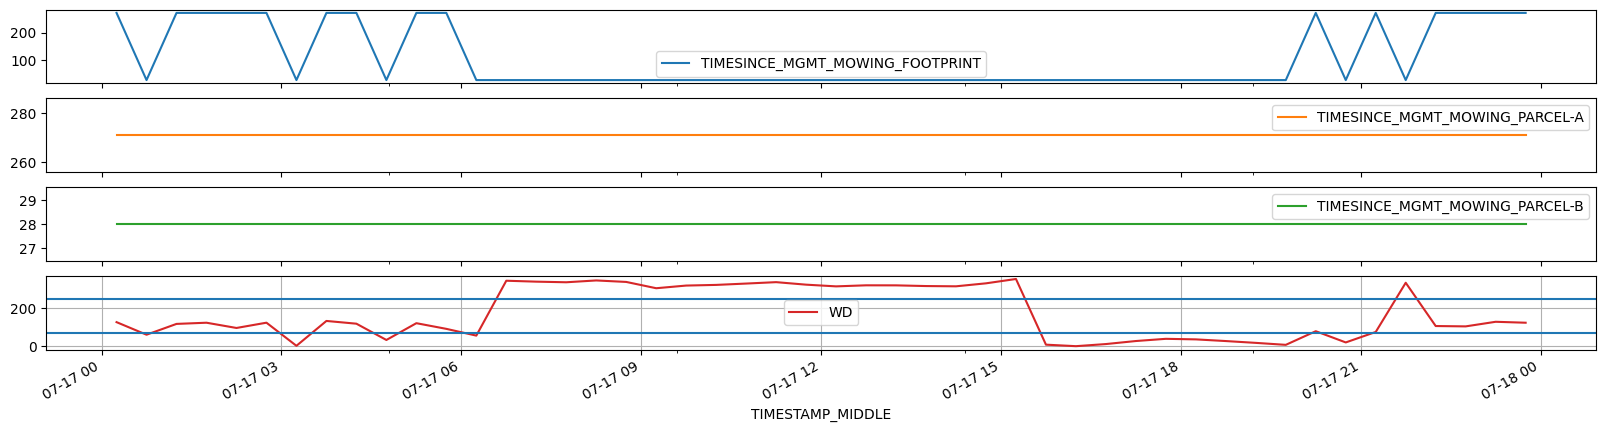

In [53]:
locs = (mgmt_hh.index.year == 2014) & (mgmt_hh.index.month == 7) & (mgmt_hh.index.day == 17)
mgmt_hh.loc[locs, ['TIMESINCE_MGMT_MOWING_FOOTPRINT', 'TIMESINCE_MGMT_MOWING_PARCEL-A', 'TIMESINCE_MGMT_MOWING_PARCEL-B', 'WD']].plot(x_compat=True, subplots=True, figsize=(20, 5))
plt.axhline(250)
plt.axhline(70)
plt.grid();

## Plot complete management dataframe

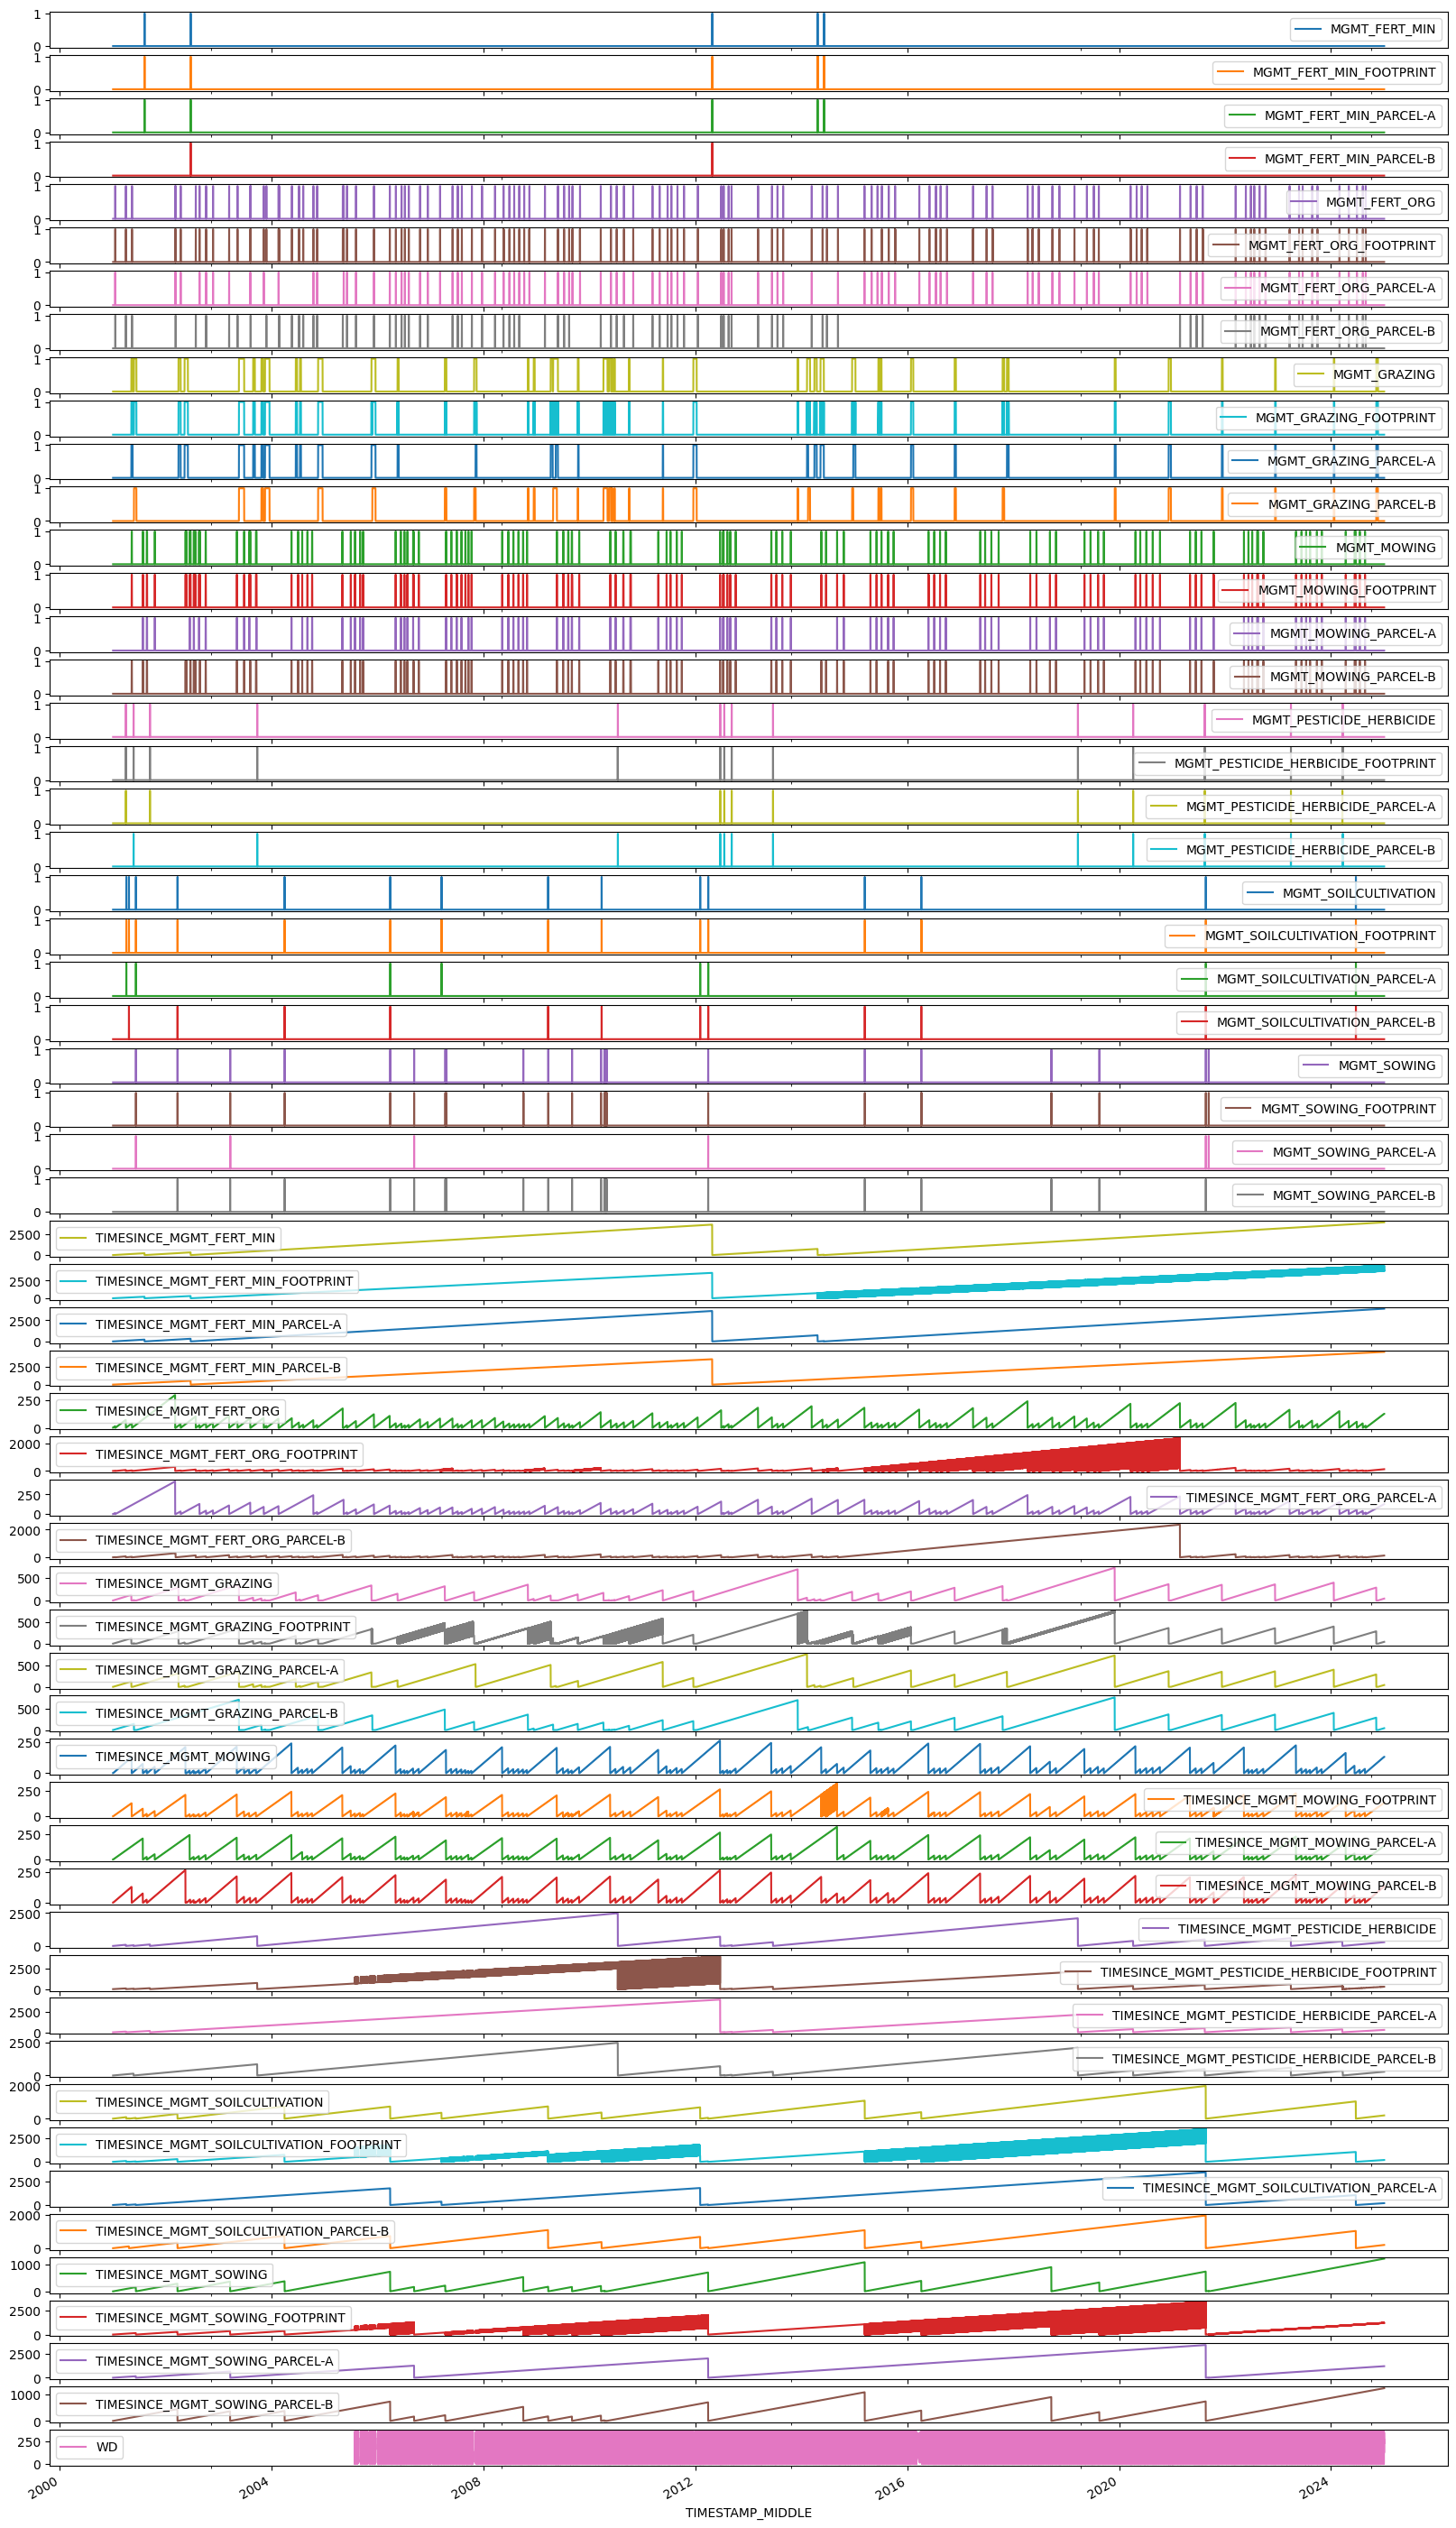

In [54]:
plt.rcParams["figure.dpi"] = 100
mgmt_hh.plot(x_compat=True, subplots=True, figsize=(20, 40));

</br>

</br>

---

# Export data to file

---

## Keep management info from 2005 onwards

In [55]:
keeplocs = (mgmt_hh.index.year >= 2005) & (mgmt_hh.index.year <= 2024)
mgmt_hh = mgmt_hh.loc[keeplocs].copy()
mgmt_hh

MGMT_FERT_MIN  MGMT_FERT_MIN_FOOTPRINT  MGMT_FERT_MIN_PARCEL-A  MGMT_FERT_MIN_PARCEL-B  MGMT_FERT_ORG  MGMT_FERT_ORG_FOOTPRINT  MGMT_FERT_ORG_PARCEL-A  MGMT_FERT_ORG_PARCEL-B  MGMT_GRAZING  MGMT_GRAZING_FOOTPRINT  MGMT_GRAZING_PARCEL-A  MGMT_GRAZING_PARCEL-B  MGMT_MOWING  MGMT_MOWING_FOOTPRINT  MGMT_MOWING_PARCEL-A  ...  TIMESINCE_MGMT_MOWING_PARCEL-A  TIMESINCE_MGMT_MOWING_PARCEL-B  TIMESINCE_MGMT_PESTICIDE_HERBICIDE  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_FOOTPRINT  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-A  TIMESINCE_MGMT_PESTICIDE_HERBICIDE_PARCEL-B  TIMESINCE_MGMT_SOILCULTIVATION  TIMESINCE_MGMT_SOILCULTIVATION_FOOTPRINT  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-A  TIMESINCE_MGMT_SOILCULTIVATION_PARCEL-B  TIMESINCE_MGMT_SOWING  TIMESINCE_MGMT_SOWING_FOOTPRINT  TIMESINCE_MGMT_SOWING_PARCEL-A  TIMESINCE_MGMT_SOWING_PARCEL-B       WD
TIMESTAMP_MIDDLE                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2005-01-01 00:15:00            0.0                      0.0                       0                       0            0.0                      0.0                       0                       0           0.0                     0.0                      0                      0          0.0                    0.0                     0  ...                              88                              88                                 467                                         467.0                                         1207                                          467                             278                                     278.0                                     1304                                      278                    278                            278.0                             653                             278      NaN
2005-01-01 00:45:00            0.0                      0.0                       0                       0            0.0                      0.0                       0                       0           0.0                     0.0                      0                      0          0.0                    0.0                     0  ...                              88                              88                                 467                                         467.0                                         1207                                          467                             278                                     278.0                                     1304                                      278                    278                            278.0                             653                             278      NaN
2005-01-01 01:15:00            0.0                      0.0                       0                       0            0.0                      0.0                       0                       0           0.0                     0.0                      0                      0          0.0                    0.0                     0  ...                              88                              88                                 467                                         467.0                                         1207                                

## Save to file

In [56]:
mgmt_hh.to_csv("22.5_mgmt_full_timestamp.csv")